You can find all the data in `../readonly/final_project_data` folder or download it from [Kaggle](https://inclass.kaggle.com/c/competitive-data-science-final-project) if you are solving locally. 

**Good luck!**

# 1. Competition Overview
In this competition you will work with a challenging **time-series** dataset consisting of daily sales data, kindly provided by one of the largest Russian software firms - 1C Company. 

### File descriptions
- **sales_train.csv** - the training set. Daily historical data from January 2013 to October 2015.
- **test.csv** - the test set. You need to forecast the sales for these shops and products for November 2015.
- **sample_submission.csv** - a sample submission file in the correct format.
- **items.csv** - supplemental information about the items/products.
- **item_categories.csv**  - supplemental information about the items categories.
- **shops.csv**- supplemental information about the shops.


## 1.1 Loading Libraries

In [58]:
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
%matplotlib inline 

pd.set_option('display.max_rows', 600)
pd.set_option('display.max_columns', 50)

import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import seaborn as sns # for making plots with seaborn
from tqdm import tqdm_notebook
color = sns.color_palette()
sns.set()

from itertools import product

Validation = False

## 1.2 Load data
Submissions are evaluated by **root mean squared error (RMSE)**. True target values are clipped into [0,20] range.

In [59]:
sales = pd.read_csv('sales_train.csv.gz')
shops = pd.read_csv('shops.csv')
items = pd.read_csv('items.csv')
item_cats = pd.read_csv('item_categories.csv')
test = pd.read_csv('test.csv.gz')
submission = pd.read_csv('sample_submission.csv.gz')

Let's check data shapes.

In [3]:
print('Size of sales :', sales.shape)
print('Size of test :', test.shape)
print('Size of shops :', shops.shape)
print('Size of items :', items.shape)
print('Size of item_cats :', item_cats.shape)


Size of sales : (2935849, 6)
Size of test : (214200, 3)
Size of shops : (60, 2)
Size of items : (22170, 3)
Size of item_cats : (84, 2)


# 2. Explorary Data Analysis
- **item_cnt_day** - number of products sold. You are predicting a monthly amount of this measure
- **date_block_num** - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33

In [4]:
print('Train Unique shops :', len(sales['shop_id'].unique()))
print('Test Unique shops :', len(test['shop_id'].unique()))
print('Train Unique items:', len(sales['item_id'].unique()))
print('Test Unique items :', len(test['item_id'].unique()))
print('min item prize :', min(sales['item_price']))
print('max item prize :', max(sales['item_price']))

Train Unique shops : 60
Test Unique shops : 42
Train Unique items: 21807
Test Unique items : 5100
min item prize : -1.0
max item prize : 307980.0


In [5]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [6]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [7]:
item_cats.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [8]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


Convert the `item['date']` to pandas date format

In [56]:
sales['date'] = pd.to_datetime(sales['date'], format = '%d.%m.%Y')

Add **item_category_id** to **sales** as a feature

In [10]:
sales['item_category_id'] = sales['item_id'].map(sales['item_id'].map(items['item_category_id']))
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
0,02.01.2013,0,59,22154,999.00,1.0,43
1,03.01.2013,0,25,2552,899.00,1.0,40
2,05.01.2013,0,25,2552,899.00,-1.0,40
3,06.01.2013,0,25,2554,1709.05,1.0,37
4,15.01.2013,0,25,2555,1099.00,1.0,30


## 2.1 Check for missing data
It seems look pretty good that there is no missing data.

In [9]:
sales.isnull().sum().sort_values(ascending = False)

item_cnt_day      0
item_price        0
item_id           0
shop_id           0
date_block_num    0
date              0
dtype: int64

In [10]:
sales[sales['item_id'] == 11373].sort_values(['item_price'])

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2909818,28.10.2015,33,12,11373,0.908714,2169.0
2257993,31.12.2014,23,12,11373,38.500000,4.0
2048642,30.10.2014,21,12,11373,71.000000,2.0
1058343,29.11.2013,10,12,11373,72.200000,105.0
2462729,26.02.2015,25,12,11373,75.454545,11.0
1398729,21.02.2014,13,12,11373,76.000000,5.0
2608354,24.04.2015,27,12,11373,76.083333,12.0
2257974,09.12.2014,23,12,11373,77.500000,8.0
2626184,22.05.2015,28,12,11373,79.677419,31.0
2731663,23.07.2015,30,12,11373,80.000000,7.0


In [11]:
sales[sales['item_id'] == 11365].sort_values(['item_price'])

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
1651714,16.05.2014,16,12,11365,124.000000,5.0
2805487,21.08.2015,31,12,11365,170.000000,2.0
1330776,13.01.2014,12,12,11365,180.000000,3.0
1398688,25.02.2014,13,12,11365,194.000000,5.0
661581,05.07.2013,6,12,11365,230.000000,4.0
2731490,30.07.2015,30,12,11365,230.000000,1.0
1398683,06.02.2014,13,12,11365,246.666667,9.0
2626123,21.05.2015,28,12,11365,248.333333,6.0
2608316,16.04.2015,27,12,11365,249.333333,15.0
1058265,29.11.2013,10,12,11365,260.867925,53.0


In [60]:
# Correct sale_train values
sales['item_price'][2909818] = np.nan
sales['item_cnt_day'][2909818] = np.nan
sales['item_price'][2909818] = sales[(sales['shop_id'] ==12) & (sales['item_id'] == 11373) & (sales['date_block_num'] == 33)]['item_price'].median()
sales['item_cnt_day'][2909818] = round(sales[(sales['shop_id'] ==12) & (sales['item_id'] == 11373) & (sales['date_block_num'] == 33)]['item_cnt_day'].median())
sales['item_price'][885138] = np.nan
sales['item_price'][885138] = sales[(sales['item_id'] == 11365) & (sales['shop_id'] ==12) & (sales['date_block_num'] == 8)]['item_price'].median()


C:\Users\minori\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\minori\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\minori\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing t

## 2.2 Distribution of item_price

percentage : 0.9884765871814252


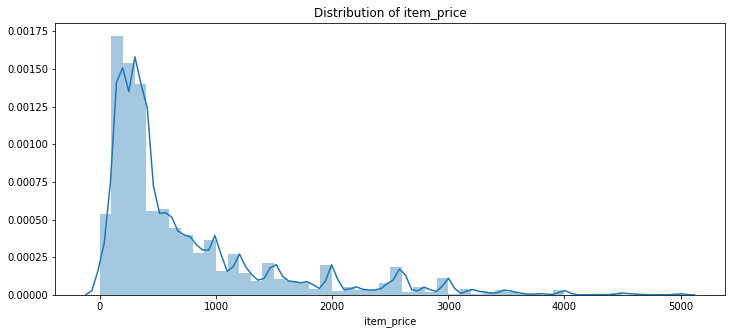

In [13]:
plt.figure(figsize=(12,5))
plt.title("Distribution of item_price")
ax = sns.distplot(sales[sales['item_price']<5000]['item_price'])
print('percentage :', len(sales[sales['item_price']<5000])/sales.shape[0])

percentage : 0.9999989781490806


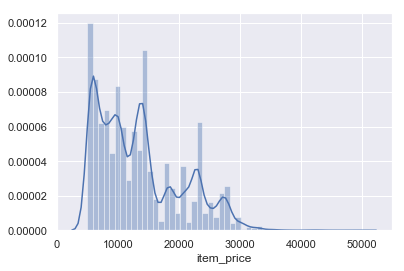

In [71]:
ax = sns.distplot(sales[(sales['item_price']>5000) & (sales['item_price']<50000)]['item_price'])
print('percentage :', len(sales[sales['item_price']<50000])/sales.shape[0])

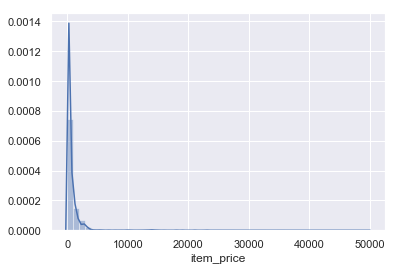

In [72]:
ax = sns.distplot(sales[sales['item_price']<50000]['item_price'])

Check some high item_price ID in both train set and test set.

Check the item_name.

In [16]:
set(sales[sales['item_price']>40000]['item_id']).intersection(set(test['item_id']))

{11365, 13403}

In [17]:
sales[sales['item_price']>40000]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
885138,17.09.2013,8,12,11365,59200.0,1.0,75
1006638,24.10.2013,9,12,7238,42000.0,1.0,30
1163158,13.12.2013,11,12,6066,307980.0,1.0,37
1488135,20.03.2014,14,25,13199,50999.0,1.0,37
2143903,20.11.2014,22,12,14173,40900.0,1.0,64
2327159,29.01.2015,24,12,7241,49782.0,1.0,40
2885692,23.10.2015,33,42,13403,42990.0,1.0,30
2893100,20.10.2015,33,38,13403,41990.0,1.0,30
2910155,20.10.2015,33,12,13403,41990.0,1.0,30
2910156,29.10.2015,33,12,13403,42990.0,1.0,30


In [18]:
sales[sales['item_id']==11365]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
58283,09.01.2013,0,12,11365,1148.000000,5.0,75
58284,10.01.2013,0,12,11365,2235.000000,2.0,75
58285,14.01.2013,0,12,11365,1753.333333,3.0,75
58286,15.01.2013,0,12,11365,1435.000000,2.0,75
58287,16.01.2013,0,12,11365,1930.000000,1.0,75
58289,17.01.2013,0,12,11365,1115.000000,6.0,75
58318,21.01.2013,0,12,11365,1600.000000,1.0,75
58319,24.01.2013,0,12,11365,3170.000000,1.0,75
58320,25.01.2013,0,12,11365,1620.000000,1.0,75
58350,28.01.2013,0,12,11365,920.000000,1.0,75


In [19]:
print(items[items['item_id']==13403]['item_name'])
print(items[items['item_id']==11365]['item_name'])

13403    Комплект "Microsoft Xbox One 1TB  Limited Edit...
Name: item_name, dtype: object
11365    Доставка (EMS)
Name: item_name, dtype: object


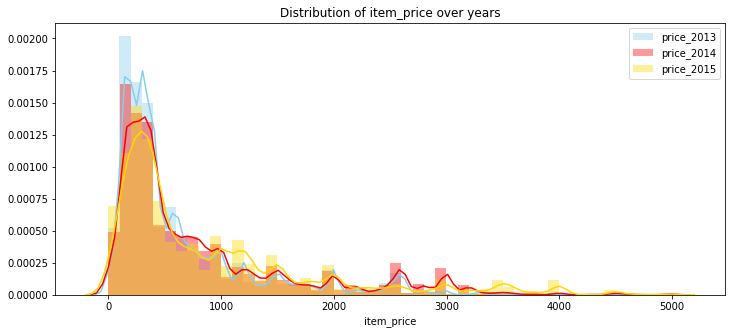

In [20]:
plt.figure(figsize=(12,5))
plt.title("Distribution of item_price over years")

price_2013 = sales[(sales['item_price']<5000) & (sales['date_block_num']<13)]['item_price']
price_2014 = sales[(sales['item_price']<5000) & (sales['date_block_num']<25) & (sales['date_block_num']>12)]['item_price']
price_2015 = sales[(sales['item_price']<5000) & (24<sales['date_block_num'])]['item_price']

sns.distplot( price_2013 , color="skyblue", label="price_2013")
sns.distplot( price_2014 , color="red", label="price_2014")
sns.distplot( price_2015 , color="gold", label="price_2015")
plt.legend()

## 2.3 Distribution of shop_id

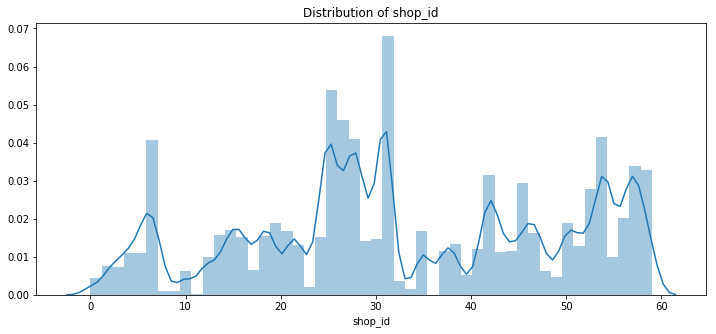

In [21]:
plt.figure(figsize=(12,5))
plt.title("Distribution of shop_id")
ax = sns.distplot(sales['shop_id'])

In [22]:
sales[(sales['date_block_num']<13)].groupby('shop_id').item_cnt_day

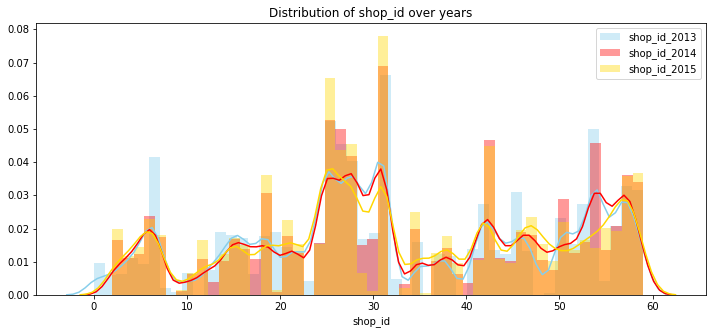

In [23]:
plt.figure(figsize=(12,5))
plt.title("Distribution of shop_id over years")

shop_id_2013 = sales[(sales['date_block_num']<13)]['shop_id']
shop_id_2014 = sales[(sales['date_block_num']<25) & (sales['date_block_num']>12)]['shop_id']
shop_id_2015 = sales[(24<sales['date_block_num'])]['shop_id']

sns.distplot( shop_id_2013 , color="skyblue", label="shop_id_2013")
sns.distplot( shop_id_2014 , color="red", label="shop_id_2014")
sns.distplot( shop_id_2015 , color="gold", label="shop_id_2015")
plt.legend()

## 2.4 Distribution of item_category_id

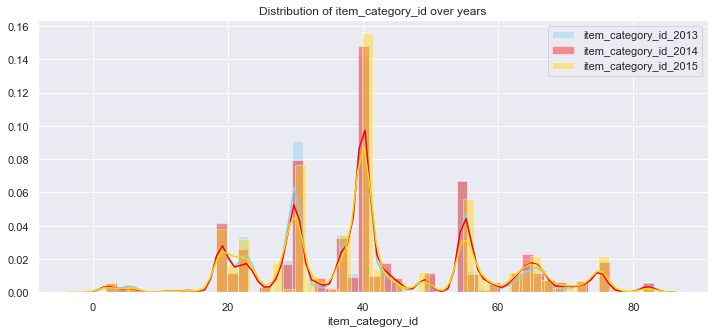

In [69]:
plt.figure(figsize=(12,5))
plt.title("Distribution of item_category_id over years")

item_category_id_2013 = sales[(sales['date_block_num']<13)]['item_category_id']
item_category_id_2014 = sales[(sales['date_block_num']<25) & (sales['date_block_num']>12)]['item_category_id']
item_category_id_2015 = sales[(24<sales['date_block_num'])]['item_category_id']

sns.distplot( item_category_id_2013 , color="skyblue", label="item_category_id_2013")
sns.distplot( item_category_id_2014 , color="red", label="item_category_id_2014")
sns.distplot( item_category_id_2015 , color="gold", label="item_category_id_2015")
plt.legend()

## 2.5 Distribution of item_id

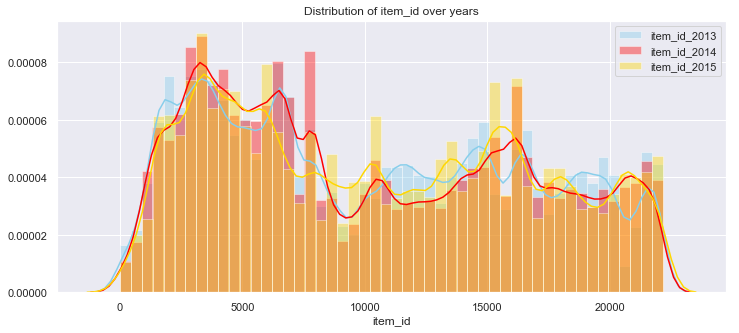

In [70]:
plt.figure(figsize=(12,5))
plt.title("Distribution of item_id over years")

item_id_2013 = sales[(sales['date_block_num']<13)]['item_id']
item_id_2014 = sales[(sales['date_block_num']<25) & (sales['date_block_num']>12)]['item_id']
item_id_2015 = sales[(24<sales['date_block_num'])]['item_id']

sns.distplot( item_id_2013 , color="skyblue", label="item_id_2013")
sns.distplot( item_id_2014 , color="red", label="item_id_2014")
sns.distplot( item_id_2015 , color="gold", label="item_id_2015")
plt.legend()

## 2.6 item_cnt_month over years

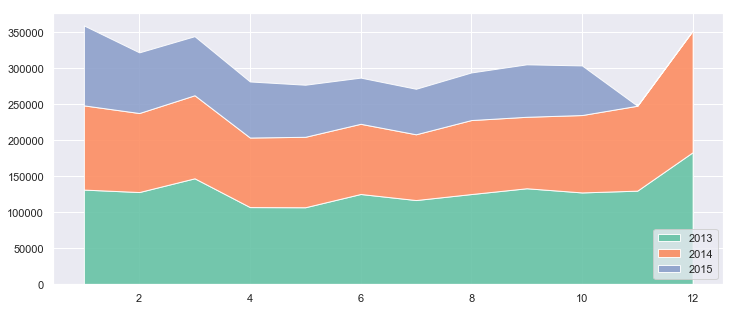

In [33]:
plt.figure(figsize=(12,5))
x = range(1,13)
ys = sales.groupby(['date_block_num'],as_index=False)['item_cnt_day'].agg('sum')['item_cnt_day']
y = [list(ys[:12]), list(ys[12:24]), list(ys[24:])+[0,0]]
pal = sns.color_palette("Set2")
plt.stackplot(x,y, labels=['2013','2014','2015'], colors=pal, alpha=0.9 )
plt.legend(loc='lower right')

## 2.7 Relation between item_price and item_id

<Figure size 864x864 with 0 Axes>

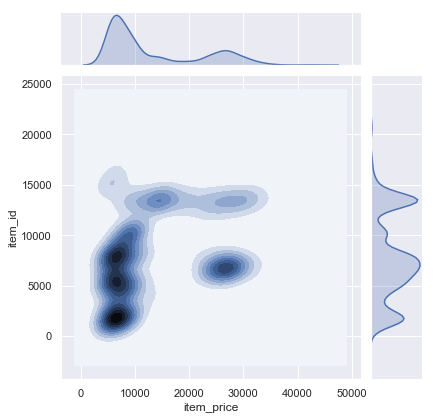

In [76]:
plt.figure(figsize=(12,12))
sns.jointplot(x=sales[(sales['item_price']>5000) & (24<sales['date_block_num'])]['item_price'], y=sales[(sales['item_price']>5000) & (24<sales['date_block_num'])]['item_id'], kind='kde')

<Figure size 864x864 with 0 Axes>

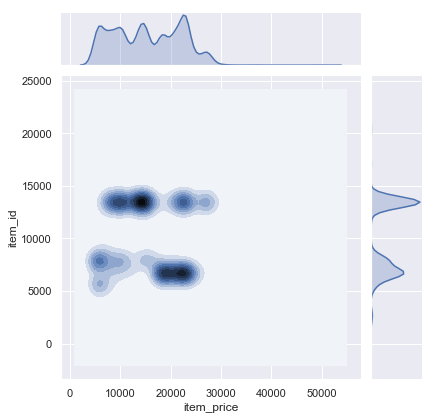

In [77]:
plt.figure(figsize=(12,12))
sns.jointplot(x=sales[(sales['item_price']>5000) & (sales['date_block_num']<25) & (sales['date_block_num']>12)]['item_price'], y=sales[(sales['item_price']>5000) & (sales['date_block_num']<25) & (sales['date_block_num']>12)]['item_id'], kind='kde')

<Figure size 864x864 with 0 Axes>

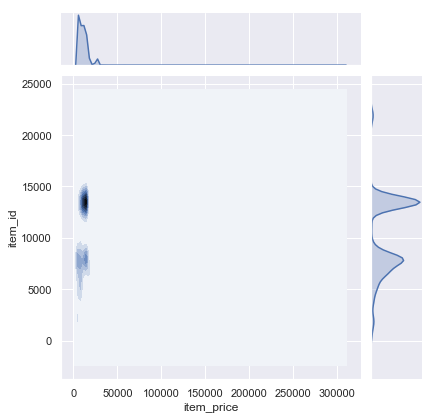

In [78]:
plt.figure(figsize=(12,12))
sns.jointplot(x=sales[(sales['item_price']>5000) & (sales['date_block_num']<13)]['item_price'], y=sales[(sales['item_price']>5000) & (sales['date_block_num']<13)]['item_id'], kind='kde')

<Figure size 864x864 with 0 Axes>

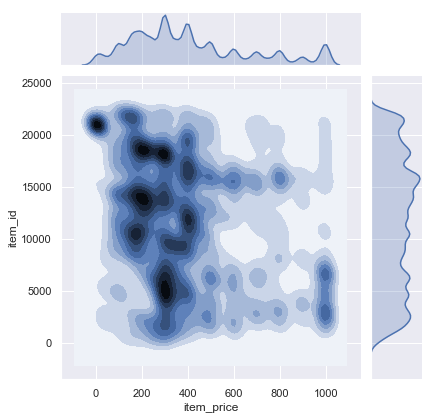

In [80]:
plt.figure(figsize=(12,12))
sns.jointplot(x=sales[(sales['item_price']<1000) & (24<sales['date_block_num'])]['item_price'], y=sales[(sales['item_price']<1000) & (24<sales['date_block_num'])]['item_id'], kind='kde')

# 3. Feature Engineering

In [61]:
sales = sales.merge(test[['shop_id']].drop_duplicates(), how = 'inner')
sales['date'] = pd.to_datetime(sales['date'], format='%d.%m.%Y')

## 3.1 Get a feature matrix

In [62]:
# Create "grid" with columns
index_cols = ['shop_id', 'item_id', 'date_block_num']

# For every month we create a grid from all shops/items combinations from that month
grid = [] 
for block_num in sales['date_block_num'].unique():
    cur_shops = sales.loc[sales['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = sales.loc[sales['date_block_num'] == block_num, 'item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

# Turn the grid into a dataframe
grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)

# Groupby data to get shop-item-month aggregates
sales['item_cnt_day'] = sales['item_cnt_day'].clip(0,20)
gb = sales.groupby(index_cols,as_index=False)['item_cnt_day'].agg('sum').rename(columns = {'item_cnt_day': 'item_cnt_month'})
gb['item_cnt_month'] = gb['item_cnt_month'].clip(0,20).astype(np.int)
# Join it to the grid
all_data = pd.merge(grid, gb, how='left', on=index_cols).fillna(0)

# Same as above but with shop-month aggregates
gb = sales.groupby(['shop_id', 'date_block_num'],as_index=False)['item_cnt_day'].agg('sum').rename(columns = {'item_cnt_day': 'target_shop'})
gb['target_shop'] = gb['target_shop'].clip(0,20).astype(np.int)
# Join it to the grid
all_data = pd.merge(all_data, gb, how='left', on=['shop_id', 'date_block_num']).fillna(0)

# Same as above but with item-month aggregates
gb = sales.groupby(['item_id', 'date_block_num'],as_index=False)['item_cnt_day'].agg('sum').rename(columns = {'item_cnt_day': 'target_item'})
gb['target_item'] = gb['target_item'].clip(0,20).astype(np.int)
# Join it to the grid
all_data = pd.merge(all_data, gb, how='left', on=['item_id', 'date_block_num']).fillna(0)


In [63]:
def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

# Downcast dtypes from 64 to 32 bit to save memory
all_data = downcast_dtypes(all_data)
del grid, gb 
gc.collect();

In [64]:
all_data.sort_values(['date_block_num','shop_id','item_id'],inplace=True)
all_data.head()

,shop_id,item_id,date_block_num,item_cnt_month,target_shop,target_item
84203,2,19,0,0.0,20,1
86531,2,27,0,1.0,20,6
88912,2,28,0,0.0,20,8
87693,2,29,0,0.0,20,4
83623,2,32,0,0.0,20,20


In [30]:
# Sanity check
print(sales['item_cnt_day'].sum())
print(all_data['item_cnt_month'].sum())

3582120.0
3261311.0


Add **item_category_id** to **sales** as a feature

In [65]:
all_data = all_data.merge(items[['item_id', 'item_category_id']], on = ['item_id'], how = 'left')
test = test.merge(items[['item_id', 'item_category_id']], on = ['item_id'], how = 'left')

In [20]:
all_data.head()

,shop_id,item_id,date_block_num,item_cnt_month,target_shop,target_item,item_category_id
0,2,19,0,0.0,20,1,40
1,2,27,0,1.0,20,6,19
2,2,28,0,0.0,20,8,30
3,2,29,0,0.0,20,4,23
4,2,32,0,0.0,20,20,40


In [21]:
item_cats.shape

(84, 2)

In [66]:
l_cat = list(item_cats.item_category_name)

for ind in range(0,1):l_cat[ind] = 'PC Headsets / Headphones'
for ind in range(1,8):l_cat[ind] = 'Access'
l_cat[8] = 'Tickets (figure)'
l_cat[9] = 'Delivery of goods'
for ind in range(10,18):l_cat[ind] = 'Consoles'
for ind in range(18,25):l_cat[ind] = 'Consoles Games'
l_cat[25] = 'Accessories for games'
for ind in range(26,28):l_cat[ind] = 'phone games'
for ind in range(28,32):l_cat[ind] = 'CD games'
for ind in range(32,37):l_cat[ind] = 'Card'
for ind in range(37,43):l_cat[ind] = 'Movie'
for ind in range(43,55):l_cat[ind] = 'Books'
for ind in range(55,61):l_cat[ind] = 'Music'
for ind in range(61,73):l_cat[ind] = 'Gifts'
for ind in range(73,79):l_cat[ind] = 'Soft'
for ind in range(79,81):l_cat[ind] = 'Office'
for ind in range(81,83):l_cat[ind] = 'Clean'
l_cat[83] = 'Elements of a food'

In [67]:
from sklearn import preprocessing

lb = preprocessing.LabelEncoder()
item_cats['item_cat_id_fix'] = lb.fit_transform(l_cat)

all_data = all_data.merge(item_cats[['item_cat_id_fix', 'item_category_id']], on = ['item_category_id'], how = 'left')
test = test.merge(item_cats[['item_cat_id_fix', 'item_category_id']], on = ['item_category_id'], how = 'left')
all_data.head()

,shop_id,item_id,date_block_num,item_cnt_month,target_shop,target_item,item_category_id,item_cat_id_fix
0,2,19,0,0.0,20,1,40,11
1,2,27,0,1.0,20,6,19,7
2,2,28,0,0.0,20,8,30,3
3,2,29,0,0.0,20,4,23,7
4,2,32,0,0.0,20,20,40,11


In [68]:
del items, item_cats
gc.collect();

## 3.3 Mean encodings features

In [23]:
all_data.head()

,shop_id,item_id,date_block_num,item_cnt_month,target_shop,target_item,item_category_id,item_cat_id_fix
0,0,19,0,0.0,20,1,40,11
1,0,27,0,0.0,20,7,19,7
2,0,28,0,0.0,20,8,30,3
3,0,29,0,0.0,20,5,23,7
4,0,32,0,6.0,20,20,40,11


### 3.3.1 KFold scheme regularization

In [69]:
from sklearn.model_selection import KFold

mean_encoded_col = ['shop_id', 'item_id', 'item_category_id', 'item_cat_id_fix']
global_mean =  all_data['item_cnt_month'].mean()

for col in tqdm_notebook(mean_encoded_col):
    kf = KFold(n_splits=5,shuffle=False, random_state = 0)
    all_data[col+'_enc_kf'] = np.nan

    for train_index , test_index in kf.split(all_data['item_cnt_month'].values):
        x_tr, x_val = all_data.iloc[train_index], all_data.iloc[test_index]
        means = x_val[col].map(x_tr.groupby(col).item_cnt_month.mean())
        all_data[col+'_enc_kf'].iloc[test_index] = means
    
    # Fill NaNs
    all_data[col+'_enc_kf'].fillna(global_mean, inplace=True) 
    corr = np.corrcoef(all_data['item_cnt_month'].values, all_data[col+'_enc_kf'])[0][1]
    print(col+'_enc_kf',corr)
    
    # Drop if correlation < 0.3
#     if corr < 0.3:
#         all_data.drop(columns=[col+'_enc_kf'], inplace=True)

C:\Users\minori\Anaconda3\envs\tensorflow\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


shop_id_enc_kf 0.17337045864056277
item_id_enc_kf 0.31586214733336654
item_category_id_enc_kf 0.27407179596715203
item_cat_id_fix_enc_kf 0.15732343270016874



In [25]:
all_data.head()

,shop_id,item_id,date_block_num,item_cnt_month,target_shop,target_item,item_category_id,item_cat_id_fix,item_id_enc_kf
0,0,19,0,0.0,20,1,40,11,0.298823
1,0,27,0,0.0,20,7,19,7,0.048523
2,0,28,0,0.0,20,8,30,3,0.142424
3,0,29,0,0.0,20,5,23,7,0.030303
4,0,32,0,6.0,20,20,40,11,0.895534


### 3.3.2 Leave-one-out scheme regularization

In [70]:
for col in tqdm_notebook(mean_encoded_col):
    all_data[col+'_enc_loo'] = np.nan

    all_data[col+'_enc_loo'] = all_data.groupby(col)['item_cnt_month'].transform('sum') - all_data['item_cnt_month']
    all_data[col+'_enc_loo'] /= (all_data.groupby(col)['item_cnt_month'].transform('count')-1)
    
    # Fill NaNs
    all_data[col+'_enc_loo'].fillna(global_mean, inplace=True) 
    corr = np.corrcoef(all_data['item_cnt_month'].values, all_data[col+'_enc_loo'])[0][1]
    print(col+'_enc_loo',corr)
    
    # Drop if correlation < 0.3
#     if corr < 0.3:
#         all_data.drop(columns=[col+'_enc_loo'], inplace=True)

shop_id_enc_loo 0.17554681313306436
item_id_enc_loo 0.4819368416124951
item_category_id_enc_loo 0.2927779834798382
item_cat_id_fix_enc_loo 0.17159342731824384



In [27]:
all_data.head()

,shop_id,item_id,date_block_num,item_cnt_month,target_shop,target_item,item_category_id,item_cat_id_fix,item_id_enc_kf,item_id_enc_loo
0,0,19,0,0.0,20,1,40,11,0.298823,0.022727
1,0,27,0,0.0,20,7,19,7,0.048523,0.056911
2,0,28,0,0.0,20,8,30,3,0.142424,0.143098
3,0,29,0,0.0,20,5,23,7,0.030303,0.040625
4,0,32,0,6.0,20,20,40,11,0.895534,1.280126


### 3.3.3 Smoothing regularization

In [71]:
for col in tqdm_notebook(mean_encoded_col):
    all_data[col+'_enc_smoo'] = np.nan

    alpha = 100
    mean_target = all_data.groupby(col)['item_cnt_month'].transform('mean')
    nrow = all_data.groupby(col)['item_cnt_month'].transform('count') 
    all_data[col+'_enc_smoo'] = (mean_target*nrow + 0.3343*alpha)/(nrow+alpha)
    
    # Fill NaNs
    all_data[col+'_enc_smoo'].fillna(global_mean, inplace=True) 
    corr = np.corrcoef(all_data['item_cnt_month'].values, all_data[col+'_enc_smoo'])[0][1]
    print(col+'_enc_smoo',corr)
    
    # Drop if correlation < 0.3
#     if corr < 0.3:
#         all_data.drop(columns=[col+'_enc_smoo'], inplace=True)

shop_id_enc_smoo 0.17557235554506093
item_id_enc_smoo 0.47976679311611814
item_category_id_enc_smoo 0.2927316906354779
item_cat_id_fix_enc_smoo 0.1716387693172654



In [29]:
all_data.head()

,shop_id,item_id,date_block_num,item_cnt_month,target_shop,target_item,item_category_id,item_cat_id_fix,item_id_enc_kf,item_id_enc_loo,item_id_enc_smoo
0,0,19,0,0.0,20,1,40,11,0.298823,0.022727,0.237448
1,0,27,0,0.0,20,7,19,7,0.048523,0.056911,0.089905
2,0,28,0,0.0,20,8,30,3,0.142424,0.143098,0.170403
3,0,29,0,0.0,20,5,23,7,0.030303,0.040625,0.110285
4,0,32,0,6.0,20,20,40,11,0.895534,1.280126,1.226827


### 3.3.4 Expanding mean scheme regularization

In [72]:
for col in tqdm_notebook(mean_encoded_col):
    all_data[col+'_enc_expan'] = np.nan

    cumsum = all_data.groupby(col)['item_cnt_month'].cumsum()-all_data['item_cnt_month']
    cumcnt = all_data.groupby(col)['item_cnt_month'].cumcount()
    all_data[col+'_enc_expan'] = cumsum/cumcnt
    
    # Fill NaNs
    all_data[col+'_enc_expan'].fillna(global_mean, inplace=True) 
    corr = np.corrcoef(all_data['item_cnt_month'].values, all_data[col+'_enc_expan'])[0][1]
    print(col+'_enc_expan',corr)
    
    # Drop if correlation < 0.3
#     if corr < 0.3:
#         all_data.drop(columns=[col+'_enc_expan'], inplace=True)

shop_id_enc_expan 0.17574555214870394
item_id_enc_expan 0.5656456891458477
item_category_id_enc_expan 0.2961041783359048
item_cat_id_fix_enc_expan 0.1768452301105094



In [31]:
all_data.head()

,shop_id,item_id,date_block_num,item_cnt_month,target_shop,target_item,item_category_id,item_cat_id_fix,item_id_enc_kf,item_id_enc_loo,item_id_enc_smoo,item_id_enc_expan
0,0,19,0,0.0,20,1,40,11,0.298823,0.022727,0.237448,0.298823
1,0,27,0,0.0,20,7,19,7,0.048523,0.056911,0.089905,0.298823
2,0,28,0,0.0,20,8,30,3,0.142424,0.143098,0.170403,0.298823
3,0,29,0,0.0,20,5,23,7,0.030303,0.040625,0.110285,0.298823
4,0,32,0,6.0,20,20,40,11,0.895534,1.280126,1.226827,0.298823


## 3.3 Lag-based features
We generate both train and test lag-based features together.

In [73]:
# Uncomment following when submitting
if Validation == False:
    test['date_block_num'] = 34
    all_data = pd.concat([all_data, test], axis = 0)
    all_data = all_data.drop(columns = ['ID'])

C:\Users\minori\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


In [35]:
all_data

,date_block_num,item_cat_id_fix,item_category_id,item_cnt_month,item_id,item_id_enc_expan,item_id_enc_kf,item_id_enc_loo,item_id_enc_smoo,shop_id,target_item,target_shop
0,0,11,40,0.0,19,0.298823,0.298823,0.022727,0.237448,0,1.0,20.0
1,0,7,19,0.0,27,0.298823,0.048523,0.056911,0.089905,0,7.0,20.0
2,0,3,30,0.0,28,0.298823,0.142424,0.143098,0.170403,0,8.0,20.0
3,0,7,23,0.0,29,0.298823,0.030303,0.040625,0.110285,0,5.0,20.0
4,0,11,40,6.0,32,0.298823,0.895534,1.280126,1.226827,0,20.0,20.0
5,0,11,37,3.0,33,0.298823,0.487509,0.528076,0.518049,0,20.0,20.0
6,0,11,40,0.0,34,0.298823,0.107018,0.146283,0.166235,0,9.0,20.0
7,0,11,40,1.0,35,0.298823,0.020408,0.944444,0.762478,0,20.0,20.0
8,0,12,57,0.0,40,0.298823,0.054717,0.070997,0.089425,0,4.0,20.0
9,0,12,57,0.0,41,0.298823,0.038136,0.086000,0.127171,0,9.0,20.0


In [74]:
index_cols = ['shop_id', 'item_id', 'item_category_id', 'item_cat_id_fix', 'date_block_num']
cols_to_rename = list(all_data.columns.difference(index_cols))
shift_range = [1, 2, 3, 4, 5, 6, 12]

for month_shift in tqdm_notebook(shift_range):
    train_shift = all_data[index_cols + cols_to_rename].copy()
    
    train_shift['date_block_num'] = train_shift['date_block_num'] + month_shift
    
    foo = lambda x: '{}_lag_{}'.format(x, month_shift) if x in cols_to_rename else x
    train_shift = train_shift.rename(columns=foo)

    all_data = pd.merge(all_data, train_shift, on=index_cols, how='left').fillna(0)

del train_shift
gc.collect();

In [75]:
# Don't use old data from year 2013
all_data = all_data[all_data['date_block_num'] >= 12] 
all_data

,date_block_num,item_cat_id_fix,item_cat_id_fix_enc_expan,item_cat_id_fix_enc_kf,item_cat_id_fix_enc_loo,item_cat_id_fix_enc_smoo,item_category_id,item_category_id_enc_expan,item_category_id_enc_kf,item_category_id_enc_loo,item_category_id_enc_smoo,item_cnt_month,item_id,item_id_enc_expan,item_id_enc_kf,item_id_enc_loo,item_id_enc_smoo,shop_id,shop_id_enc_expan,shop_id_enc_kf,shop_id_enc_loo,shop_id_enc_smoo,target_item,target_shop,item_cat_id_fix_enc_expan_lag_1,...,shop_id_enc_expan_lag_6,shop_id_enc_kf_lag_6,shop_id_enc_loo_lag_6,shop_id_enc_smoo_lag_6,target_item_lag_6,target_shop_lag_6,item_cat_id_fix_enc_expan_lag_12,item_cat_id_fix_enc_kf_lag_12,item_cat_id_fix_enc_loo_lag_12,item_cat_id_fix_enc_smoo_lag_12,item_category_id_enc_expan_lag_12,item_category_id_enc_kf_lag_12,item_category_id_enc_loo_lag_12,item_category_id_enc_smoo_lag_12,item_cnt_month_lag_12,item_id_enc_expan_lag_12,item_id_enc_kf_lag_12,item_id_enc_loo_lag_12,item_id_enc_smoo_lag_12,shop_id_enc_expan_lag_12,shop_id_enc_kf_lag_12,shop_id_enc_loo_lag_12,shop_id_enc_smoo_lag_12,target_item_lag_12,target_shop_lag_12
3352934,12,11,0.240344,0.223743,0.227192,0.227196,40,0.256568,0.252354,0.253682,0.253686,0.0,30,2.573201,1.058107,0.998453,0.950093,2,0.104497,0.133303,0.130480,0.130571,20.0,20.0,0.236116,...,0.093518,0.142101,0.130480,0.130571,20.0,20.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
3352935,12,11,0.240344,0.223743,0.227192,0.227196,37,0.207911,0.178791,0.185897,0.185914,0.0,31,1.821340,0.866917,0.802011,0.767884,2,0.104496,0.133303,0.130480,0.130571,15.0,20.0,0.236116,...,0.093516,0.142101,0.130480,0.130571,13.0,20.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
3352936,12,11,0.240344,0.223743,0.227192,0.227196,40,0.256568,0.252354,0.253681,0.253686,1.0,32,2.412844,1.173636,1.264706,1.199320,2,0.104495,0.133303,0.130475,0.130571,20.0,20.0,0.236116,...,0.093514,0.142101,0.130480,0.130571,20.0,20.0,0.000000,0.224664,0.227192,0.227196,0.000000,0.254899,0.253682,0.253686,0.0,0.310685,0.902262,1.265460,1.199320,0.250000,0.142101,0.130480,0.130571,20.0,20.0
3352937,12,11,0.240344,0.223743,0.227192,0.227196,37,0.207910,0.178791,0.185896,0.185914,1.0,33,0.793578,0.468182,0.527903,0.514667,2,0.104504,0.133303,0.130475,0.130571,20.0,20.0,0.236115,...,0.093512,0.142101,0.130480,0.130571,20.0,20.0,0.000000,0.224664,0.227192,0.227196,0.310685,0.183915,0.185896,0.185914,1.0,0.310685,0.480543,0.527903,0.514667,0.200000,0.142101,0.130475,0.130571,20.0,20.0
3352938,12,11,0.240345,0.223743,0.227192,0.227196,40,0.256569,0.252354,0.253682,0.253686,0.0,34,0.211009,0.193846,0.183303,0.206181,2,0.104514,0.133303,0.130480,0.130571,5.0,20.0,0.236116,...,0.093510,0.142101,0.130480,0.130571,12.0,20.0,0.333333,0.224664,0.227192,0.227196,0.000000,0.254899,0.253682,0.253686,0.0,0.310685,0.139394,0.183303,0.206181,0.333333,0.142101,0.130480,0.130571,8.0,20.0
3352939,12,11,0.240345,0.223743,0.227192,0.227196,37,0.207913,0.178791,0.185897,0.185914,0.0,36,0.121588,0.070201,0.077922,0.102859,2,0.104513,0.133303,0.130480,0.130571,2.0,20.0,0.236116,...,0.093508,0.142101,0.130480,0.130571,4.0,20.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
3352940,12,11,0.240345,0.223743,0.227192,0.227196,40,0.256568,0.252354,0.253682,0.253686,0.0,37,0.257453,0.116236,0.148438,0.169655,2,0.104512,0.133303,0.130480,0.130571,3.0,20.0,0.236116,...,0.093506,0.142101,0.130480,0.130571,7.0,20.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
3352941,12,11,0.240344,0.223743,0.227192,0.227196,41,0.195364,0.166584,0.170340,0.170439,0.0,39,0.052632,0.028302,0.032051,0.149533,2

In [76]:
lag_cols = [col for col in all_data.columns if col[-1] in [str(item) for item in shift_range]]
all_data = downcast_dtypes(all_data)

## 3.4 Date features

In [77]:
# Get dates from *sales dataframe*
sales['date'] = pd.to_datetime(sales['date'], format='%d.%m.%Y')
dates_train = sales[['date', 'date_block_num']].drop_duplicates()
dates_test = dates_train[dates_train['date_block_num'] == 34-12]
dates_test['date_block_num'] = 34
dates_test['date'] = dates_test['date'] + pd.DateOffset(years=1)
dates_all = pd.concat([dates_train, dates_test])


# Generate date features
dates_all['dow'] = dates_all['date'].dt.dayofweek
dates_all['year'] = dates_all['date'].dt.year
dates_all['month'] = dates_all['date'].dt.month

# Convert categorical variable into dummy/indicator variables
dates_all = pd.get_dummies(dates_all, columns=['dow']) 
dow_col = ['dow_' + str(x) for x in range(7)]
date_features = dates_all.groupby(['year', 'month', 'date_block_num'])[dow_col].agg('sum').reset_index()
date_features['days_of_month'] = date_features[dow_col].sum(axis=1)
date_features['year'] = date_features['year'] - 2013

# Merge date_features to all_data
#date_features = date_features[['month', 'year', 'days_of_month', 'date_block_num']]
all_data = all_data.merge(date_features, on = 'date_block_num', how = 'left')
date_columns = date_features.columns.difference(set(index_cols))
all_data.head()

C:\Users\minori\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\minori\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,date_block_num,item_cat_id_fix,item_cat_id_fix_enc_expan,item_cat_id_fix_enc_kf,item_cat_id_fix_enc_loo,item_cat_id_fix_enc_smoo,item_category_id,item_category_id_enc_expan,item_category_id_enc_kf,item_category_id_enc_loo,item_category_id_enc_smoo,item_cnt_month,item_id,item_id_enc_expan,item_id_enc_kf,item_id_enc_loo,item_id_enc_smoo,shop_id,shop_id_enc_expan,shop_id_enc_kf,shop_id_enc_loo,shop_id_enc_smoo,target_item,target_shop,item_cat_id_fix_enc_expan_lag_1,...,item_category_id_enc_expan_lag_12,item_category_id_enc_kf_lag_12,item_category_id_enc_loo_lag_12,item_category_id_enc_smoo_lag_12,item_cnt_month_lag_12,item_id_enc_expan_lag_12,item_id_enc_kf_lag_12,item_id_enc_loo_lag_12,item_id_enc_smoo_lag_12,shop_id_enc_expan_lag_12,shop_id_enc_kf_lag_12,shop_id_enc_loo_lag_12,shop_id_enc_smoo_lag_12,target_item_lag_12,target_shop_lag_12,year,month,dow_0,dow_1,dow_2,dow_3,dow_4,dow_5,dow_6,days_of_month
0,12,11,0.240344,0.223743,0.227192,0.227196,40,0.256568,0.252354,0.253682,0.253686,0.0,30,2.573201,1.058107,0.998453,0.950093,2,0.104497,0.133303,0.130480,0.130571,20.0,20.0,0.236116,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1,1,4,4,5,5,5,4,4,31
1,12,11,0.240344,0.223743,0.227192,0.227196,37,0.207911,0.178791,0.185897,0.185914,0.0,31,1.821340,0.866917,0.802011,0.767884,2,0.104496,0.133303,0.130480,0.130571,15.0,20.0,0.236116,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1,1,4,4,5,5,5,4,4,31
2,12,11,0.240344,0.223743,0.227192,0.227196,40,0.256568,0.252354,0.253681,0.253686,1.0,32,2.412844,1.173636,1.264706,1.199320,2,0.104495,0.133303,0.130475,0.130571,20.0,20.0,0.236116,...,0.000000,0.254899,0.253682,0.253686,0.0,0.310685,0.902262,1.265460,1.199320,0.250000,0.142101,0.130480,0.130571,20.0,20.0,1,1,4,4,5,5,5,4,4,31
3,12,11,0.240344,0.223743,0.227192,0.227196,37,0.207910,0.178791,0.185896,0.185914,1.0,33,0.793578,0.468182,0.527903,0.514667,2,0.104504,0.133303,0.130475,0.130571,20.0,20.0,0.236115,...,0.310685,0.183915,0.185896,0.185914,1.0,0.310685,0.480543,0.527903,0.514667,0.200000,0.142101,0.130475,0.130571,20.0,20.0,1,1,4,4,5,5,5,4,4,31
4,12,11,0.240345,0.223743,0.227192,0.227196,40,0.256569,0.252354,0.253682,0.253686,0.0,34,0.211009,0.193846,0.183303,0.206181,2,0.104514,0.133303,0.130480,0.130571,5.0,20.0,0.236116,...,0.000000,0.254899,0.253682,0.253686,0.0,0.310685,0.139394,0.183303,0.206181,0.333333,0.142101,0.130480,0.130571,8.0,20.0,1,1,4,4,5,5,5,4,4,31


## 3.5 Scale feature columns

In [78]:
from sklearn.preprocessing import StandardScaler

# Initialize StandardScaler and split data to assure the same distribution
sc = StandardScaler()
train = all_data[all_data['date_block_num']!= all_data['date_block_num'].max()]
test = all_data[all_data['date_block_num']== all_data['date_block_num'].max()]

# Select columns to be standardized
to_drop_cols = ['date_block_num']
feature_columns = list(set(lag_cols + index_cols + list(date_columns)).difference(to_drop_cols))

# fit_transform
train[feature_columns] = sc.fit_transform(train[feature_columns])
test[feature_columns] = sc.transform(test[feature_columns])
all_data = pd.concat([train, test], axis = 0)

# Downcast for standardized data
all_data = downcast_dtypes(all_data)

C:\Users\minori\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
C:\Users\minori\Anaconda3\envs\tensorflow\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\minori\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

In [41]:
all_data.head()

,date_block_num,item_cat_id_fix,item_category_id,item_cnt_month,item_id,item_id_enc_expan,item_id_enc_kf,item_id_enc_loo,item_id_enc_smoo,shop_id,target_item,target_shop,item_cnt_month_lag_1,item_id_enc_expan_lag_1,item_id_enc_kf_lag_1,item_id_enc_loo_lag_1,item_id_enc_smoo_lag_1,target_item_lag_1,target_shop_lag_1,item_cnt_month_lag_2,item_id_enc_expan_lag_2,item_id_enc_kf_lag_2,item_id_enc_loo_lag_2,item_id_enc_smoo_lag_2,target_item_lag_2,target_shop_lag_2,item_cnt_month_lag_3,item_id_enc_expan_lag_3,item_id_enc_kf_lag_3,item_id_enc_loo_lag_3,item_id_enc_smoo_lag_3,target_item_lag_3,target_shop_lag_3,item_cnt_month_lag_4,item_id_enc_expan_lag_4,item_id_enc_kf_lag_4,item_id_enc_loo_lag_4,item_id_enc_smoo_lag_4,target_item_lag_4,target_shop_lag_4,item_cnt_month_lag_12,item_id_enc_expan_lag_12,item_id_enc_kf_lag_12,item_id_enc_loo_lag_12,item_id_enc_smoo_lag_12,target_item_lag_12,target_shop_lag_12,month,year,days_of_month
0,12,-0.651193,-1.650131,0.0,-1.792746,0.065814,0.067542,0.056911,0.089905,-1.731624,1.0,20.0,-0.240176,-0.379625,-0.384630,-0.407448,-0.387300,-0.389888,0.519609,-0.238877,-0.365656,-0.369931,-0.393283,-0.368474,-0.651761,0.564722,-0.236147,-0.359584,-0.354812,-0.377180,-0.348770,-0.081363,0.61163,-0.233201,-0.342261,-0.339195,-0.360041,-0.328562,-0.744354,0.657764,0.647994,0.198983,-0.221020,-0.229000,-0.171674,0.309241,1.062901,-1.49091,-0.794314,0.658798
1,12,0.471781,-0.312874,0.0,-1.792268,2.735060,1.220146,1.087013,1.040481,-1.731624,20.0,20.0,-0.240176,2.277774,1.080945,1.201142,1.264990,1.835759,0.519609,-0.238877,2.448241,1.148756,1.250390,1.304415,1.832462,0.564722,-0.236147,2.740088,1.229160,1.300992,1.349771,1.840306,0.61163,-0.233201,3.144455,1.312202,1.350993,1.395561,0.895397,0.657764,-0.204651,-0.307826,-0.325317,-0.341868,-0.366677,-0.680157,-0.940966,-1.49091,-0.794314,0.658798
2,12,0.471781,-0.503911,0.0,-1.792108,1.958167,0.995126,0.861688,0.829025,-1.731624,16.0,20.0,-0.240176,1.523713,0.775967,0.849279,0.897437,1.835759,0.519609,-0.238877,1.664457,0.832725,0.890853,0.932280,1.832462,0.564722,-0.236147,1.861378,0.899544,0.933909,0.971929,1.840306,0.61163,-0.233201,2.129379,0.968555,0.976721,1.012029,1.715272,0.657764,-0.204651,-0.307826,-0.325317,-0.341868,-0.366677,-0.680157,-0.940966,-1.49091,-0.794314,0.658798
3,12,0.471781,-0.312874,1.0,-1.791949,2.404022,1.370690,1.283281,1.226827,-1.731624,20.0,20.0,-0.240176,1.845357,1.135011,1.508616,1.588895,1.835759,0.519609,-0.238877,1.889274,1.204781,1.564570,1.632358,1.832462,0.564722,-0.236147,2.014035,1.287594,1.621766,1.682742,1.840306,0.61163,-0.233201,2.167540,1.373123,1.678048,1.733548,1.851918,0.657764,-0.204651,6.280685,1.599572,2.266568,2.294317,2.146693,1.062901,-1.49091,-0.794314,0.658798
4,12,0.471781,-0.503911,1.0,-1.791789,0.767824,0.525862,0.529338,0.518049,-1.731624,20.0,20.0,0.580449,0.265675,0.167722,0.330286,0.356899,1.835759,0.519609,1.386522,0.308394,0.202438,0.359534,0.385003,1.142400,0.564722,-0.236147,0.324340,0.242162,0.393493,0.416260,1.840306,0.61163,-0.233201,0.317687,0.283190,0.425723,0.447991,1.851918,0.657764,0.647994,1.212600,0.722551,0.733551,0.756973,2.146693,1.062901,-1.49091,-0.794314,0.658798


# 4. Validation
The **two-level stacking** model is used to take advantages from different models(linear, Xgboost, NN, etc).

Save `date_block_num`, as we can't use them as features, but will need them to split the dataset into parts.

In [79]:
dates = all_data['date_block_num']
last_block = dates.max()
print('Test `date_block_num` is %d' % last_block)
print('Number of features; ' ,len(feature_columns))

Test `date_block_num` is 34
Number of features;  147


## 4.1 First-level model

Here the **time-series validation** scheme is used.
- 1. Split the train data into chunks of duration **T**. Select first **M** chunks.
- 2. Fit **N** diverse models on those **M** chunks and predict for the chunk **M+1**. Then fit those models on first **M+1** chunks and predict for chunk **M+2** and so on, until you hit the end. After that use all train data to fit models and get predictions for test. Now we will have **meta-features** for the chunks starting from number **M+1** as well as **meta-features** for the test.
- 3. Now we can use **meta-features** from first **K** chunks **[M+1,M+2,..,M+K]** to fit level 2 models and validate them on chunk **M+K+1**. Essentially we are back to step 1. with the lesser amount of chunks and **meta-features** instead of features.

In [80]:
from sklearn.metrics import mean_squared_error
from math import sqrt

num_first_level_models = 3
scoringMethod = 'r2'

# Train meta-features M = 15 (12 + 15 = 27)
months_to_generate_meta_features = range(27,last_block +1)
mask = dates.isin(months_to_generate_meta_features)
Target = 'item_cnt_month'
y_all_level2 = all_data[Target][mask].values
X_all_level2 = np.zeros([y_all_level2.shape[0], num_first_level_models])

Now fill `X_train_level2` with **meta-features**

In [82]:
slice_start = 0
SEED = 0

for cur_block_num in tqdm_notebook(months_to_generate_meta_features):
    # Use M chunks to predict for the chunk M+1
    cur_X_train = all_data.loc[dates <  cur_block_num][feature_columns]
    cur_X_test =  all_data.loc[dates == cur_block_num][feature_columns]
    cur_y_train = all_data.loc[dates <  cur_block_num, Target].values
    cur_y_test =  all_data.loc[dates == cur_block_num, Target].values

    # Create Numpy arrays of train, test and target dataframes to feed into models
    train_x = cur_X_train.values
    train_y = cur_y_train.ravel()
    test_x = cur_X_test.values
    test_y = cur_y_test.ravel()
    preds = []

    from sklearn.linear_model import (LinearRegression, SGDRegressor)
    import lightgbm as lgb

    sgdr= SGDRegressor(
        penalty = 'l2' ,
        random_state = SEED )
    lgb_params = {'feature_fraction': 0.75,
                  'metric': 'rmse',
                  'nthread':16,
                  'min_data_in_leaf': 2**7,
                  'bagging_fraction': 0.75,
                  'learning_rate': 0.03,
                  'objective': 'mse',
                  'bagging_seed': 2**7,
                  'num_leaves': 2**7,
                  'bagging_freq':1,
                  'verbose':0}
    estimators = [sgdr]

    for estimator in estimators:
        estimator.fit(train_x, train_y)
        pred_test = estimator.predict(test_x)
        preds.append(pred_test)

        # pred_train = estimator.predict(train_x)
        # print('Train RMSE for %s is %f' % (estimator.__class__.__name__, sqrt(mean_squared_error(cur_y_train, pred_train))))
        # print('Test RMSE for %s is %f' % (estimator.__class__.__name__, sqrt(mean_squared_error(cur_y_test, pred_test))))

    print('Training Model %d: %s'%(len(preds), 'lightgbm'))
    estimator = lgb.train(lgb_params, lgb.Dataset(train_x, label=train_y), 300)
    pred_test = estimator.predict(test_x)
    preds.append(pred_test)

    # pred_train = estimator.predict(train_x)
    # print('Train RMSE for %s is %f' % ('lightgbm', sqrt(mean_squared_error(cur_y_train, pred_train))))
    # print('Test RMSE for %s is %f' % ('lightgbm', sqrt(mean_squared_error(cur_y_test, pred_test))))

    print('Training Model %d: %s'%(len(preds), 'keras'))
    from keras.models import Sequential
    from keras.layers import Dense
    from keras.wrappers.scikit_learn import KerasRegressor

    def baseline_model():
        # create model
        model = Sequential()
        model.add(Dense(50, input_dim=train_x.shape[1], kernel_initializer='glorot_normal', activation='softplus'))
        model.add(Dropout(0.2))
        model.add(Dense(50, kernel_initializer='glorot_normal', activation = 'relu'))
        model.add(Dropout(0.2))
        model.add(Dense(20, kernel_initializer='glorot_normal', activation = 'relu'))
        model.add(Dropout(0.2))
        model.add(Dense(20, kernel_initializer='glorot_normal', activation = 'relu'))
        model.add(Dropout(0.2))
        model.add(Dense(1, kernel_initializer='glorot_normal', activation = 'relu'))

        # Compile model
        model.compile(loss='mse', optimizer='adam', metrics=['mse'])
        # model.compile(loss='mean_squared_error', optimizer='adam')
        return model

    estimator = KerasRegressor(build_fn=baseline_model, verbose=1, epochs=10, batch_size = 55000)
    estimator.fit(train_x, train_y)
    pred_test = estimator.predict(test_x)
    preds.append(pred_test)

    slice_end = slice_start + cur_X_test.shape[0]
    X_all_level2[ slice_start : slice_end , :] = np.c_[preds].transpose()
    slice_start = slice_end

C:\Users\minori\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Training Model 1: lightgbm
Training Model 2: keras
Epoch 1/10
3746814/3746814 [==============================] - ETA: 1:42 - loss: 1.5894 - mean_squared_error: 1.58 - ETA: 1:02 - loss: 1.6221 - mean_squared_error: 1.62 - ETA: 48s - loss: 1.6603 - mean_squared_error: 1.6603 - ETA: 41s - loss: 1.6325 - mean_squared_error: 1.632 - ETA: 36s - loss: 1.6161 - mean_squared_error: 1.616 - ETA: 33s - loss: 1.6064 - mean_squared_error: 1.606 - ETA: 31s - loss: 1.5872 - mean_squared_error: 1.587 - ETA: 29s - loss: 1.5786 - mean_squared_error: 1.578 - ETA: 28s - loss: 1.5775 - mean_squared_error: 1.577 - ETA: 26s - loss: 1.5683 - mean_squared_error: 1.568 - ETA: 25s - loss: 1.5622 - mean_squared_error: 1.562 - ETA: 24s - loss: 1.5534 - mean_squared_error: 1.553 - ETA: 24s - loss: 1.5413 - mean_squared_error: 1.541 - ETA: 23s - loss: 1.5340 - mean_squared_error: 1.534 - ETA: 22s - loss: 1.5255 - mean_squared_error: 1.525 - ETA: 21s - loss: 1.5213 - mean_squared_error: 1.521 - ETA: 21s - loss: 1.507

3746814/3746814 [==============================] - ETA: 33s - loss: 1.0266 - mean_squared_error: 1.026 - ETA: 27s - loss: 0.9655 - mean_squared_error: 0.965 - ETA: 25s - loss: 0.9366 - mean_squared_error: 0.936 - ETA: 24s - loss: 0.9496 - mean_squared_error: 0.949 - ETA: 23s - loss: 0.9409 - mean_squared_error: 0.940 - ETA: 23s - loss: 0.9477 - mean_squared_error: 0.947 - ETA: 22s - loss: 0.9494 - mean_squared_error: 0.949 - ETA: 21s - loss: 0.9414 - mean_squared_error: 0.941 - ETA: 21s - loss: 0.9438 - mean_squared_error: 0.943 - ETA: 20s - loss: 0.9498 - mean_squared_error: 0.949 - ETA: 20s - loss: 0.9439 - mean_squared_error: 0.943 - ETA: 20s - loss: 0.9479 - mean_squared_error: 0.947 - ETA: 19s - loss: 0.9459 - mean_squared_error: 0.945 - ETA: 19s - loss: 0.9514 - mean_squared_error: 0.951 - ETA: 18s - loss: 0.9506 - mean_squared_error: 0.950 - ETA: 18s - loss: 0.9499 - mean_squared_error: 0.949 - ETA: 18s - loss: 0.9473 - mean_squared_error: 0.947 - ETA: 17s - loss: 0.9495 - mean_

3746814/3746814 [==============================] - ETA: 33s - loss: 0.9178 - mean_squared_error: 0.917 - ETA: 27s - loss: 0.9449 - mean_squared_error: 0.944 - ETA: 25s - loss: 0.9156 - mean_squared_error: 0.915 - ETA: 24s - loss: 0.9134 - mean_squared_error: 0.913 - ETA: 23s - loss: 0.9198 - mean_squared_error: 0.919 - ETA: 23s - loss: 0.9119 - mean_squared_error: 0.911 - ETA: 22s - loss: 0.9114 - mean_squared_error: 0.911 - ETA: 21s - loss: 0.8993 - mean_squared_error: 0.899 - ETA: 21s - loss: 0.8964 - mean_squared_error: 0.896 - ETA: 20s - loss: 0.8957 - mean_squared_error: 0.895 - ETA: 20s - loss: 0.8959 - mean_squared_error: 0.895 - ETA: 19s - loss: 0.8944 - mean_squared_error: 0.894 - ETA: 19s - loss: 0.8918 - mean_squared_error: 0.891 - ETA: 19s - loss: 0.8919 - mean_squared_error: 0.891 - ETA: 18s - loss: 0.8891 - mean_squared_error: 0.889 - ETA: 18s - loss: 0.8912 - mean_squared_error: 0.891 - ETA: 18s - loss: 0.8936 - mean_squared_error: 0.893 - ETA: 17s - loss: 0.8910 - mean_

3746814/3746814 [==============================] - ETA: 32s - loss: 0.8794 - mean_squared_error: 0.879 - ETA: 27s - loss: 0.8956 - mean_squared_error: 0.895 - ETA: 25s - loss: 0.8874 - mean_squared_error: 0.887 - ETA: 24s - loss: 0.8727 - mean_squared_error: 0.872 - ETA: 23s - loss: 0.8738 - mean_squared_error: 0.873 - ETA: 22s - loss: 0.8774 - mean_squared_error: 0.877 - ETA: 22s - loss: 0.8760 - mean_squared_error: 0.876 - ETA: 21s - loss: 0.8739 - mean_squared_error: 0.873 - ETA: 21s - loss: 0.8645 - mean_squared_error: 0.864 - ETA: 20s - loss: 0.8709 - mean_squared_error: 0.870 - ETA: 20s - loss: 0.8709 - mean_squared_error: 0.870 - ETA: 20s - loss: 0.8741 - mean_squared_error: 0.874 - ETA: 19s - loss: 0.8738 - mean_squared_error: 0.873 - ETA: 19s - loss: 0.8754 - mean_squared_error: 0.875 - ETA: 18s - loss: 0.8808 - mean_squared_error: 0.880 - ETA: 18s - loss: 0.8814 - mean_squared_error: 0.881 - ETA: 18s - loss: 0.8786 - mean_squared_error: 0.878 - ETA: 17s - loss: 0.8767 - mean_

3746814/3746814 [==============================] - ETA: 33s - loss: 0.8353 - mean_squared_error: 0.835 - ETA: 28s - loss: 0.8276 - mean_squared_error: 0.827 - ETA: 26s - loss: 0.8493 - mean_squared_error: 0.849 - ETA: 25s - loss: 0.8696 - mean_squared_error: 0.869 - ETA: 24s - loss: 0.8794 - mean_squared_error: 0.879 - ETA: 23s - loss: 0.8777 - mean_squared_error: 0.877 - ETA: 23s - loss: 0.8730 - mean_squared_error: 0.873 - ETA: 22s - loss: 0.8764 - mean_squared_error: 0.876 - ETA: 21s - loss: 0.8754 - mean_squared_error: 0.875 - ETA: 21s - loss: 0.8836 - mean_squared_error: 0.883 - ETA: 20s - loss: 0.8801 - mean_squared_error: 0.880 - ETA: 20s - loss: 0.8753 - mean_squared_error: 0.875 - ETA: 20s - loss: 0.8706 - mean_squared_error: 0.870 - ETA: 19s - loss: 0.8741 - mean_squared_error: 0.874 - ETA: 19s - loss: 0.8741 - mean_squared_error: 0.874 - ETA: 18s - loss: 0.8696 - mean_squared_error: 0.869 - ETA: 18s - loss: 0.8722 - mean_squared_error: 0.872 - ETA: 18s - loss: 0.8692 - mean_

3968296/3968296 [==============================] - ETA: 1:59 - loss: 1.7294 - mean_squared_error: 1.72 - ETA: 1:10 - loss: 1.7240 - mean_squared_error: 1.72 - ETA: 54s - loss: 1.6606 - mean_squared_error: 1.6606 - ETA: 46s - loss: 1.6146 - mean_squared_error: 1.614 - ETA: 41s - loss: 1.5943 - mean_squared_error: 1.594 - ETA: 37s - loss: 1.5809 - mean_squared_error: 1.580 - ETA: 35s - loss: 1.5601 - mean_squared_error: 1.560 - ETA: 33s - loss: 1.5359 - mean_squared_error: 1.535 - ETA: 31s - loss: 1.5177 - mean_squared_error: 1.517 - ETA: 30s - loss: 1.4989 - mean_squared_error: 1.498 - ETA: 28s - loss: 1.4896 - mean_squared_error: 1.489 - ETA: 27s - loss: 1.4661 - mean_squared_error: 1.466 - ETA: 26s - loss: 1.4516 - mean_squared_error: 1.451 - ETA: 25s - loss: 1.4498 - mean_squared_error: 1.449 - ETA: 25s - loss: 1.4401 - mean_squared_error: 1.440 - ETA: 24s - loss: 1.4310 - mean_squared_error: 1.431 - ETA: 23s - loss: 1.4315 - mean_squared_error: 1.431 - ETA: 22s - loss: 1.4228 - mean

3968296/3968296 [==============================] - ETA: 36s - loss: 0.9480 - mean_squared_error: 0.948 - ETA: 30s - loss: 0.9670 - mean_squared_error: 0.967 - ETA: 28s - loss: 0.9517 - mean_squared_error: 0.951 - ETA: 27s - loss: 0.9524 - mean_squared_error: 0.952 - ETA: 25s - loss: 0.9348 - mean_squared_error: 0.934 - ETA: 25s - loss: 0.9396 - mean_squared_error: 0.939 - ETA: 24s - loss: 0.9471 - mean_squared_error: 0.947 - ETA: 24s - loss: 0.9420 - mean_squared_error: 0.942 - ETA: 23s - loss: 0.9363 - mean_squared_error: 0.936 - ETA: 22s - loss: 0.9317 - mean_squared_error: 0.931 - ETA: 22s - loss: 0.9381 - mean_squared_error: 0.938 - ETA: 22s - loss: 0.9311 - mean_squared_error: 0.931 - ETA: 21s - loss: 0.9302 - mean_squared_error: 0.930 - ETA: 21s - loss: 0.9344 - mean_squared_error: 0.934 - ETA: 20s - loss: 0.9331 - mean_squared_error: 0.933 - ETA: 20s - loss: 0.9354 - mean_squared_error: 0.935 - ETA: 19s - loss: 0.9363 - mean_squared_error: 0.936 - ETA: 19s - loss: 0.9334 - mean_

3968296/3968296 [==============================] - ETA: 36s - loss: 0.8795 - mean_squared_error: 0.879 - ETA: 30s - loss: 0.8398 - mean_squared_error: 0.839 - ETA: 28s - loss: 0.8654 - mean_squared_error: 0.865 - ETA: 27s - loss: 0.8667 - mean_squared_error: 0.866 - ETA: 26s - loss: 0.8771 - mean_squared_error: 0.877 - ETA: 25s - loss: 0.8866 - mean_squared_error: 0.886 - ETA: 24s - loss: 0.8899 - mean_squared_error: 0.889 - ETA: 24s - loss: 0.8854 - mean_squared_error: 0.885 - ETA: 23s - loss: 0.8902 - mean_squared_error: 0.890 - ETA: 23s - loss: 0.8956 - mean_squared_error: 0.895 - ETA: 22s - loss: 0.8909 - mean_squared_error: 0.890 - ETA: 22s - loss: 0.8898 - mean_squared_error: 0.889 - ETA: 21s - loss: 0.8864 - mean_squared_error: 0.886 - ETA: 21s - loss: 0.8861 - mean_squared_error: 0.886 - ETA: 20s - loss: 0.8851 - mean_squared_error: 0.885 - ETA: 20s - loss: 0.8892 - mean_squared_error: 0.889 - ETA: 20s - loss: 0.8863 - mean_squared_error: 0.886 - ETA: 19s - loss: 0.8867 - mean_

3968296/3968296 [==============================] - ETA: 37s - loss: 0.8322 - mean_squared_error: 0.832 - ETA: 31s - loss: 0.8529 - mean_squared_error: 0.852 - ETA: 28s - loss: 0.8701 - mean_squared_error: 0.870 - ETA: 27s - loss: 0.8680 - mean_squared_error: 0.868 - ETA: 26s - loss: 0.8741 - mean_squared_error: 0.874 - ETA: 25s - loss: 0.8703 - mean_squared_error: 0.870 - ETA: 24s - loss: 0.8665 - mean_squared_error: 0.866 - ETA: 24s - loss: 0.8713 - mean_squared_error: 0.871 - ETA: 23s - loss: 0.8672 - mean_squared_error: 0.867 - ETA: 22s - loss: 0.8651 - mean_squared_error: 0.865 - ETA: 22s - loss: 0.8677 - mean_squared_error: 0.867 - ETA: 22s - loss: 0.8709 - mean_squared_error: 0.870 - ETA: 21s - loss: 0.8705 - mean_squared_error: 0.870 - ETA: 21s - loss: 0.8703 - mean_squared_error: 0.870 - ETA: 20s - loss: 0.8739 - mean_squared_error: 0.873 - ETA: 20s - loss: 0.8728 - mean_squared_error: 0.872 - ETA: 20s - loss: 0.8691 - mean_squared_error: 0.869 - ETA: 19s - loss: 0.8686 - mean_

3968296/3968296 [==============================] - ETA: 38s - loss: 0.8902 - mean_squared_error: 0.890 - ETA: 30s - loss: 0.8399 - mean_squared_error: 0.839 - ETA: 28s - loss: 0.8511 - mean_squared_error: 0.851 - ETA: 27s - loss: 0.8454 - mean_squared_error: 0.845 - ETA: 26s - loss: 0.8461 - mean_squared_error: 0.846 - ETA: 25s - loss: 0.8368 - mean_squared_error: 0.836 - ETA: 24s - loss: 0.8372 - mean_squared_error: 0.837 - ETA: 24s - loss: 0.8303 - mean_squared_error: 0.830 - ETA: 23s - loss: 0.8325 - mean_squared_error: 0.832 - ETA: 23s - loss: 0.8350 - mean_squared_error: 0.835 - ETA: 23s - loss: 0.8375 - mean_squared_error: 0.837 - ETA: 22s - loss: 0.8369 - mean_squared_error: 0.836 - ETA: 22s - loss: 0.8343 - mean_squared_error: 0.834 - ETA: 21s - loss: 0.8287 - mean_squared_error: 0.828 - ETA: 21s - loss: 0.8276 - mean_squared_error: 0.827 - ETA: 20s - loss: 0.8276 - mean_squared_error: 0.827 - ETA: 20s - loss: 0.8271 - mean_squared_error: 0.827 - ETA: 20s - loss: 0.8280 - mean_

4180799/4180799 [==============================] - ETA: 2:15 - loss: 1.7867 - mean_squared_error: 1.78 - ETA: 1:20 - loss: 1.7333 - mean_squared_error: 1.73 - ETA: 1:01 - loss: 1.6863 - mean_squared_error: 1.68 - ETA: 51s - loss: 1.6255 - mean_squared_error: 1.6255 - ETA: 45s - loss: 1.6206 - mean_squared_error: 1.620 - ETA: 41s - loss: 1.5701 - mean_squared_error: 1.570 - ETA: 38s - loss: 1.5505 - mean_squared_error: 1.550 - ETA: 36s - loss: 1.5424 - mean_squared_error: 1.542 - ETA: 34s - loss: 1.5207 - mean_squared_error: 1.520 - ETA: 33s - loss: 1.5082 - mean_squared_error: 1.508 - ETA: 31s - loss: 1.4994 - mean_squared_error: 1.499 - ETA: 30s - loss: 1.4853 - mean_squared_error: 1.485 - ETA: 29s - loss: 1.4711 - mean_squared_error: 1.471 - ETA: 28s - loss: 1.4662 - mean_squared_error: 1.466 - ETA: 27s - loss: 1.4634 - mean_squared_error: 1.463 - ETA: 27s - loss: 1.4509 - mean_squared_error: 1.450 - ETA: 26s - loss: 1.4507 - mean_squared_error: 1.450 - ETA: 25s - loss: 1.4399 - mean

4180799/4180799 [==============================] - ETA: 40s - loss: 1.0588 - mean_squared_error: 1.058 - ETA: 33s - loss: 1.0692 - mean_squared_error: 1.069 - ETA: 30s - loss: 1.0976 - mean_squared_error: 1.097 - ETA: 29s - loss: 1.0597 - mean_squared_error: 1.059 - ETA: 28s - loss: 1.0452 - mean_squared_error: 1.045 - ETA: 27s - loss: 1.0469 - mean_squared_error: 1.046 - ETA: 26s - loss: 1.0417 - mean_squared_error: 1.041 - ETA: 26s - loss: 1.0391 - mean_squared_error: 1.039 - ETA: 25s - loss: 1.0431 - mean_squared_error: 1.043 - ETA: 24s - loss: 1.0325 - mean_squared_error: 1.032 - ETA: 24s - loss: 1.0263 - mean_squared_error: 1.026 - ETA: 24s - loss: 1.0191 - mean_squared_error: 1.019 - ETA: 23s - loss: 1.0175 - mean_squared_error: 1.017 - ETA: 23s - loss: 1.0121 - mean_squared_error: 1.012 - ETA: 22s - loss: 1.0127 - mean_squared_error: 1.012 - ETA: 22s - loss: 1.0123 - mean_squared_error: 1.012 - ETA: 21s - loss: 1.0146 - mean_squared_error: 1.014 - ETA: 21s - loss: 1.0100 - mean_

4180799/4180799 [==============================] - ETA: 40s - loss: 0.8902 - mean_squared_error: 0.890 - ETA: 33s - loss: 0.9159 - mean_squared_error: 0.915 - ETA: 30s - loss: 0.9572 - mean_squared_error: 0.957 - ETA: 29s - loss: 0.9680 - mean_squared_error: 0.968 - ETA: 28s - loss: 0.9586 - mean_squared_error: 0.958 - ETA: 27s - loss: 0.9499 - mean_squared_error: 0.949 - ETA: 26s - loss: 0.9482 - mean_squared_error: 0.948 - ETA: 26s - loss: 0.9541 - mean_squared_error: 0.954 - ETA: 25s - loss: 0.9565 - mean_squared_error: 0.956 - ETA: 24s - loss: 0.9545 - mean_squared_error: 0.954 - ETA: 24s - loss: 0.9494 - mean_squared_error: 0.949 - ETA: 24s - loss: 0.9423 - mean_squared_error: 0.942 - ETA: 23s - loss: 0.9379 - mean_squared_error: 0.937 - ETA: 23s - loss: 0.9345 - mean_squared_error: 0.934 - ETA: 22s - loss: 0.9408 - mean_squared_error: 0.940 - ETA: 22s - loss: 0.9381 - mean_squared_error: 0.938 - ETA: 22s - loss: 0.9380 - mean_squared_error: 0.938 - ETA: 21s - loss: 0.9418 - mean_

4180799/4180799 [==============================] - ETA: 38s - loss: 0.8848 - mean_squared_error: 0.884 - ETA: 32s - loss: 0.8564 - mean_squared_error: 0.856 - ETA: 29s - loss: 0.8822 - mean_squared_error: 0.882 - ETA: 28s - loss: 0.8815 - mean_squared_error: 0.881 - ETA: 27s - loss: 0.8815 - mean_squared_error: 0.881 - ETA: 27s - loss: 0.8899 - mean_squared_error: 0.889 - ETA: 26s - loss: 0.8903 - mean_squared_error: 0.890 - ETA: 25s - loss: 0.8865 - mean_squared_error: 0.886 - ETA: 25s - loss: 0.8856 - mean_squared_error: 0.885 - ETA: 24s - loss: 0.8870 - mean_squared_error: 0.887 - ETA: 24s - loss: 0.8933 - mean_squared_error: 0.893 - ETA: 23s - loss: 0.8939 - mean_squared_error: 0.893 - ETA: 23s - loss: 0.8999 - mean_squared_error: 0.899 - ETA: 22s - loss: 0.8971 - mean_squared_error: 0.897 - ETA: 22s - loss: 0.8963 - mean_squared_error: 0.896 - ETA: 22s - loss: 0.8986 - mean_squared_error: 0.898 - ETA: 21s - loss: 0.9051 - mean_squared_error: 0.905 - ETA: 21s - loss: 0.9047 - mean_

4180799/4180799 [==============================] - ETA: 39s - loss: 0.8745 - mean_squared_error: 0.874 - ETA: 32s - loss: 0.8908 - mean_squared_error: 0.890 - ETA: 30s - loss: 0.9060 - mean_squared_error: 0.906 - ETA: 29s - loss: 0.9219 - mean_squared_error: 0.921 - ETA: 28s - loss: 0.9069 - mean_squared_error: 0.906 - ETA: 27s - loss: 0.9257 - mean_squared_error: 0.925 - ETA: 26s - loss: 0.9290 - mean_squared_error: 0.929 - ETA: 26s - loss: 0.9255 - mean_squared_error: 0.925 - ETA: 25s - loss: 0.9221 - mean_squared_error: 0.922 - ETA: 25s - loss: 0.9144 - mean_squared_error: 0.914 - ETA: 24s - loss: 0.9114 - mean_squared_error: 0.911 - ETA: 24s - loss: 0.9119 - mean_squared_error: 0.911 - ETA: 23s - loss: 0.9145 - mean_squared_error: 0.914 - ETA: 23s - loss: 0.9122 - mean_squared_error: 0.912 - ETA: 22s - loss: 0.9116 - mean_squared_error: 0.911 - ETA: 22s - loss: 0.9079 - mean_squared_error: 0.907 - ETA: 21s - loss: 0.9081 - mean_squared_error: 0.908 - ETA: 21s - loss: 0.9052 - mean_

4180799/4180799 [==============================] - ETA: 40s - loss: 0.8108 - mean_squared_error: 0.810 - ETA: 34s - loss: 0.8225 - mean_squared_error: 0.822 - ETA: 31s - loss: 0.8474 - mean_squared_error: 0.847 - ETA: 29s - loss: 0.8564 - mean_squared_error: 0.856 - ETA: 28s - loss: 0.8669 - mean_squared_error: 0.866 - ETA: 27s - loss: 0.8630 - mean_squared_error: 0.863 - ETA: 26s - loss: 0.8609 - mean_squared_error: 0.860 - ETA: 26s - loss: 0.8679 - mean_squared_error: 0.867 - ETA: 25s - loss: 0.8717 - mean_squared_error: 0.871 - ETA: 25s - loss: 0.8726 - mean_squared_error: 0.872 - ETA: 24s - loss: 0.8753 - mean_squared_error: 0.875 - ETA: 24s - loss: 0.8785 - mean_squared_error: 0.878 - ETA: 23s - loss: 0.8793 - mean_squared_error: 0.879 - ETA: 23s - loss: 0.8789 - mean_squared_error: 0.878 - ETA: 22s - loss: 0.8767 - mean_squared_error: 0.876 - ETA: 22s - loss: 0.8741 - mean_squared_error: 0.874 - ETA: 21s - loss: 0.8708 - mean_squared_error: 0.870 - ETA: 21s - loss: 0.8705 - mean_

4180799/4180799 [==============================] - ETA: 41s - loss: 0.8692 - mean_squared_error: 0.869 - ETA: 34s - loss: 0.8871 - mean_squared_error: 0.887 - ETA: 31s - loss: 0.8523 - mean_squared_error: 0.852 - ETA: 29s - loss: 0.8496 - mean_squared_error: 0.849 - ETA: 28s - loss: 0.8555 - mean_squared_error: 0.855 - ETA: 27s - loss: 0.8687 - mean_squared_error: 0.868 - ETA: 27s - loss: 0.8604 - mean_squared_error: 0.860 - ETA: 26s - loss: 0.8555 - mean_squared_error: 0.855 - ETA: 26s - loss: 0.8566 - mean_squared_error: 0.856 - ETA: 25s - loss: 0.8521 - mean_squared_error: 0.852 - ETA: 25s - loss: 0.8501 - mean_squared_error: 0.850 - ETA: 24s - loss: 0.8468 - mean_squared_error: 0.846 - ETA: 24s - loss: 0.8447 - mean_squared_error: 0.844 - ETA: 23s - loss: 0.8509 - mean_squared_error: 0.850 - ETA: 23s - loss: 0.8487 - mean_squared_error: 0.848 - ETA: 22s - loss: 0.8500 - mean_squared_error: 0.850 - ETA: 22s - loss: 0.8506 - mean_squared_error: 0.850 - ETA: 21s - loss: 0.8502 - mean_

4180799/4180799 [==============================] - ETA: 39s - loss: 0.8397 - mean_squared_error: 0.839 - ETA: 32s - loss: 0.8244 - mean_squared_error: 0.824 - ETA: 30s - loss: 0.8568 - mean_squared_error: 0.856 - ETA: 29s - loss: 0.8691 - mean_squared_error: 0.869 - ETA: 28s - loss: 0.8671 - mean_squared_error: 0.867 - ETA: 27s - loss: 0.8598 - mean_squared_error: 0.859 - ETA: 26s - loss: 0.8602 - mean_squared_error: 0.860 - ETA: 26s - loss: 0.8626 - mean_squared_error: 0.862 - ETA: 25s - loss: 0.8599 - mean_squared_error: 0.859 - ETA: 25s - loss: 0.8571 - mean_squared_error: 0.857 - ETA: 24s - loss: 0.8534 - mean_squared_error: 0.853 - ETA: 24s - loss: 0.8596 - mean_squared_error: 0.859 - ETA: 23s - loss: 0.8630 - mean_squared_error: 0.863 - ETA: 23s - loss: 0.8648 - mean_squared_error: 0.864 - ETA: 22s - loss: 0.8700 - mean_squared_error: 0.870 - ETA: 22s - loss: 0.8717 - mean_squared_error: 0.871 - ETA: 21s - loss: 0.8692 - mean_squared_error: 0.869 - ETA: 21s - loss: 0.8683 - mean_

4180799/4180799 [==============================] - ETA: 40s - loss: 0.8432 - mean_squared_error: 0.843 - ETA: 33s - loss: 0.9089 - mean_squared_error: 0.908 - ETA: 30s - loss: 0.9015 - mean_squared_error: 0.901 - ETA: 29s - loss: 0.9062 - mean_squared_error: 0.906 - ETA: 28s - loss: 0.9019 - mean_squared_error: 0.901 - ETA: 27s - loss: 0.8948 - mean_squared_error: 0.894 - ETA: 26s - loss: 0.8894 - mean_squared_error: 0.889 - ETA: 25s - loss: 0.8864 - mean_squared_error: 0.886 - ETA: 25s - loss: 0.8764 - mean_squared_error: 0.876 - ETA: 25s - loss: 0.8754 - mean_squared_error: 0.875 - ETA: 24s - loss: 0.8763 - mean_squared_error: 0.876 - ETA: 24s - loss: 0.8727 - mean_squared_error: 0.872 - ETA: 23s - loss: 0.8756 - mean_squared_error: 0.875 - ETA: 23s - loss: 0.8768 - mean_squared_error: 0.876 - ETA: 22s - loss: 0.8738 - mean_squared_error: 0.873 - ETA: 22s - loss: 0.8679 - mean_squared_error: 0.867 - ETA: 21s - loss: 0.8651 - mean_squared_error: 0.865 - ETA: 21s - loss: 0.8626 - mean_

210494/210494 [==============================] - ETA:  - ETA:  - ETA:  - 1s 3us/step
Training Model 1: lightgbm
Training Model 2: keras
Epoch 1/10


4391293/4391293 [==============================] - ETA: 2:35 - loss: 1.4822 - mean_squared_error: 1.48 - ETA: 1:30 - loss: 1.4969 - mean_squared_error: 1.49 - ETA: 1:09 - loss: 1.4803 - mean_squared_error: 1.48 - ETA: 58s - loss: 1.4703 - mean_squared_error: 1.4703 - ETA: 51s - loss: 1.4629 - mean_squared_error: 1.462 - ETA: 46s - loss: 1.4395 - mean_squared_error: 1.439 - ETA: 43s - loss: 1.4273 - mean_squared_error: 1.427 - ETA: 40s - loss: 1.4170 - mean_squared_error: 1.417 - ETA: 38s - loss: 1.3970 - mean_squared_error: 1.397 - ETA: 36s - loss: 1.4002 - mean_squared_error: 1.400 - ETA: 35s - loss: 1.3941 - mean_squared_error: 1.394 - ETA: 33s - loss: 1.3831 - mean_squared_error: 1.383 - ETA: 32s - loss: 1.3790 - mean_squared_error: 1.379 - ETA: 31s - loss: 1.3729 - mean_squared_error: 1.372 - ETA: 30s - loss: 1.3675 - mean_squared_error: 1.367 - ETA: 29s - loss: 1.3615 - mean_squared_error: 1.361 - ETA: 28s - loss: 1.3550 - mean_squared_error: 1.355 - ETA: 28s - loss: 1.3517 - mean

4391293/4391293 [==============================] - ETA: 43s - loss: 0.9726 - mean_squared_error: 0.972 - ETA: 36s - loss: 0.9566 - mean_squared_error: 0.956 - ETA: 33s - loss: 0.9508 - mean_squared_error: 0.950 - ETA: 31s - loss: 0.9589 - mean_squared_error: 0.958 - ETA: 30s - loss: 0.9554 - mean_squared_error: 0.955 - ETA: 30s - loss: 0.9724 - mean_squared_error: 0.972 - ETA: 29s - loss: 0.9670 - mean_squared_error: 0.967 - ETA: 28s - loss: 0.9798 - mean_squared_error: 0.979 - ETA: 27s - loss: 0.9706 - mean_squared_error: 0.970 - ETA: 27s - loss: 0.9701 - mean_squared_error: 0.970 - ETA: 26s - loss: 0.9720 - mean_squared_error: 0.972 - ETA: 26s - loss: 0.9732 - mean_squared_error: 0.973 - ETA: 25s - loss: 0.9773 - mean_squared_error: 0.977 - ETA: 25s - loss: 0.9815 - mean_squared_error: 0.981 - ETA: 24s - loss: 0.9776 - mean_squared_error: 0.977 - ETA: 24s - loss: 0.9692 - mean_squared_error: 0.969 - ETA: 23s - loss: 0.9733 - mean_squared_error: 0.973 - ETA: 23s - loss: 0.9670 - mean_

4391293/4391293 [==============================] - ETA: 41s - loss: 0.8131 - mean_squared_error: 0.813 - ETA: 35s - loss: 0.8499 - mean_squared_error: 0.849 - ETA: 32s - loss: 0.8661 - mean_squared_error: 0.866 - ETA: 30s - loss: 0.8807 - mean_squared_error: 0.880 - ETA: 29s - loss: 0.9006 - mean_squared_error: 0.900 - ETA: 28s - loss: 0.9122 - mean_squared_error: 0.912 - ETA: 28s - loss: 0.9114 - mean_squared_error: 0.911 - ETA: 27s - loss: 0.9089 - mean_squared_error: 0.908 - ETA: 27s - loss: 0.9037 - mean_squared_error: 0.903 - ETA: 26s - loss: 0.9067 - mean_squared_error: 0.906 - ETA: 26s - loss: 0.9080 - mean_squared_error: 0.908 - ETA: 25s - loss: 0.9054 - mean_squared_error: 0.905 - ETA: 25s - loss: 0.9023 - mean_squared_error: 0.902 - ETA: 24s - loss: 0.9018 - mean_squared_error: 0.901 - ETA: 24s - loss: 0.9014 - mean_squared_error: 0.901 - ETA: 24s - loss: 0.8969 - mean_squared_error: 0.896 - ETA: 23s - loss: 0.8980 - mean_squared_error: 0.898 - ETA: 23s - loss: 0.8965 - mean_

4391293/4391293 [==============================] - ETA: 42s - loss: 0.8865 - mean_squared_error: 0.886 - ETA: 35s - loss: 0.8736 - mean_squared_error: 0.873 - ETA: 32s - loss: 0.8729 - mean_squared_error: 0.872 - ETA: 31s - loss: 0.8709 - mean_squared_error: 0.870 - ETA: 29s - loss: 0.8709 - mean_squared_error: 0.870 - ETA: 28s - loss: 0.8761 - mean_squared_error: 0.876 - ETA: 28s - loss: 0.8703 - mean_squared_error: 0.870 - ETA: 27s - loss: 0.8707 - mean_squared_error: 0.870 - ETA: 27s - loss: 0.8675 - mean_squared_error: 0.867 - ETA: 26s - loss: 0.8722 - mean_squared_error: 0.872 - ETA: 25s - loss: 0.8714 - mean_squared_error: 0.871 - ETA: 25s - loss: 0.8743 - mean_squared_error: 0.874 - ETA: 25s - loss: 0.8787 - mean_squared_error: 0.878 - ETA: 24s - loss: 0.8789 - mean_squared_error: 0.878 - ETA: 24s - loss: 0.8774 - mean_squared_error: 0.877 - ETA: 23s - loss: 0.8828 - mean_squared_error: 0.882 - ETA: 23s - loss: 0.8842 - mean_squared_error: 0.884 - ETA: 22s - loss: 0.8848 - mean_

4391293/4391293 [==============================] - ETA: 43s - loss: 0.8378 - mean_squared_error: 0.837 - ETA: 35s - loss: 0.8489 - mean_squared_error: 0.848 - ETA: 32s - loss: 0.8500 - mean_squared_error: 0.850 - ETA: 31s - loss: 0.8618 - mean_squared_error: 0.861 - ETA: 29s - loss: 0.8656 - mean_squared_error: 0.865 - ETA: 29s - loss: 0.8649 - mean_squared_error: 0.864 - ETA: 28s - loss: 0.8710 - mean_squared_error: 0.871 - ETA: 27s - loss: 0.8673 - mean_squared_error: 0.867 - ETA: 27s - loss: 0.8662 - mean_squared_error: 0.866 - ETA: 26s - loss: 0.8756 - mean_squared_error: 0.875 - ETA: 26s - loss: 0.8719 - mean_squared_error: 0.871 - ETA: 25s - loss: 0.8712 - mean_squared_error: 0.871 - ETA: 25s - loss: 0.8756 - mean_squared_error: 0.875 - ETA: 24s - loss: 0.8738 - mean_squared_error: 0.873 - ETA: 24s - loss: 0.8711 - mean_squared_error: 0.871 - ETA: 23s - loss: 0.8700 - mean_squared_error: 0.870 - ETA: 23s - loss: 0.8670 - mean_squared_error: 0.867 - ETA: 23s - loss: 0.8707 - mean_

4391293/4391293 [==============================] - ETA: 43s - loss: 0.8843 - mean_squared_error: 0.884 - ETA: 35s - loss: 0.8528 - mean_squared_error: 0.852 - ETA: 32s - loss: 0.8504 - mean_squared_error: 0.850 - ETA: 31s - loss: 0.8611 - mean_squared_error: 0.861 - ETA: 30s - loss: 0.8577 - mean_squared_error: 0.857 - ETA: 29s - loss: 0.8694 - mean_squared_error: 0.869 - ETA: 28s - loss: 0.8642 - mean_squared_error: 0.864 - ETA: 28s - loss: 0.8758 - mean_squared_error: 0.875 - ETA: 27s - loss: 0.8756 - mean_squared_error: 0.875 - ETA: 27s - loss: 0.8749 - mean_squared_error: 0.874 - ETA: 26s - loss: 0.8698 - mean_squared_error: 0.869 - ETA: 25s - loss: 0.8663 - mean_squared_error: 0.866 - ETA: 25s - loss: 0.8619 - mean_squared_error: 0.861 - ETA: 24s - loss: 0.8594 - mean_squared_error: 0.859 - ETA: 24s - loss: 0.8569 - mean_squared_error: 0.856 - ETA: 24s - loss: 0.8535 - mean_squared_error: 0.853 - ETA: 23s - loss: 0.8520 - mean_squared_error: 0.852 - ETA: 23s - loss: 0.8525 - mean_

4391293/4391293 [==============================] - ETA: 44s - loss: 0.9486 - mean_squared_error: 0.948 - ETA: 37s - loss: 0.8893 - mean_squared_error: 0.889 - ETA: 33s - loss: 0.8765 - mean_squared_error: 0.876 - ETA: 31s - loss: 0.8657 - mean_squared_error: 0.865 - ETA: 30s - loss: 0.8575 - mean_squared_error: 0.857 - ETA: 29s - loss: 0.8555 - mean_squared_error: 0.855 - ETA: 29s - loss: 0.8542 - mean_squared_error: 0.854 - ETA: 28s - loss: 0.8605 - mean_squared_error: 0.860 - ETA: 28s - loss: 0.8581 - mean_squared_error: 0.858 - ETA: 27s - loss: 0.8491 - mean_squared_error: 0.849 - ETA: 26s - loss: 0.8421 - mean_squared_error: 0.842 - ETA: 26s - loss: 0.8428 - mean_squared_error: 0.842 - ETA: 25s - loss: 0.8418 - mean_squared_error: 0.841 - ETA: 25s - loss: 0.8360 - mean_squared_error: 0.836 - ETA: 24s - loss: 0.8338 - mean_squared_error: 0.833 - ETA: 24s - loss: 0.8331 - mean_squared_error: 0.833 - ETA: 23s - loss: 0.8352 - mean_squared_error: 0.835 - ETA: 23s - loss: 0.8390 - mean_

4391293/4391293 [==============================] - ETA: 45s - loss: 0.8857 - mean_squared_error: 0.885 - ETA: 36s - loss: 0.8493 - mean_squared_error: 0.849 - ETA: 33s - loss: 0.8567 - mean_squared_error: 0.856 - ETA: 31s - loss: 0.8581 - mean_squared_error: 0.858 - ETA: 30s - loss: 0.8516 - mean_squared_error: 0.851 - ETA: 29s - loss: 0.8487 - mean_squared_error: 0.848 - ETA: 28s - loss: 0.8460 - mean_squared_error: 0.846 - ETA: 27s - loss: 0.8434 - mean_squared_error: 0.843 - ETA: 27s - loss: 0.8413 - mean_squared_error: 0.841 - ETA: 26s - loss: 0.8356 - mean_squared_error: 0.835 - ETA: 26s - loss: 0.8343 - mean_squared_error: 0.834 - ETA: 25s - loss: 0.8422 - mean_squared_error: 0.842 - ETA: 25s - loss: 0.8463 - mean_squared_error: 0.846 - ETA: 25s - loss: 0.8507 - mean_squared_error: 0.850 - ETA: 24s - loss: 0.8463 - mean_squared_error: 0.846 - ETA: 24s - loss: 0.8486 - mean_squared_error: 0.848 - ETA: 23s - loss: 0.8478 - mean_squared_error: 0.847 - ETA: 23s - loss: 0.8476 - mean_

4391293/4391293 [==============================] - ETA: 42s - loss: 0.8655 - mean_squared_error: 0.865 - ETA: 35s - loss: 0.8297 - mean_squared_error: 0.829 - ETA: 32s - loss: 0.8303 - mean_squared_error: 0.830 - ETA: 30s - loss: 0.8190 - mean_squared_error: 0.819 - ETA: 29s - loss: 0.8227 - mean_squared_error: 0.822 - ETA: 29s - loss: 0.8292 - mean_squared_error: 0.829 - ETA: 28s - loss: 0.8286 - mean_squared_error: 0.828 - ETA: 27s - loss: 0.8387 - mean_squared_error: 0.838 - ETA: 27s - loss: 0.8344 - mean_squared_error: 0.834 - ETA: 26s - loss: 0.8262 - mean_squared_error: 0.826 - ETA: 26s - loss: 0.8264 - mean_squared_error: 0.826 - ETA: 25s - loss: 0.8296 - mean_squared_error: 0.829 - ETA: 25s - loss: 0.8314 - mean_squared_error: 0.831 - ETA: 24s - loss: 0.8323 - mean_squared_error: 0.832 - ETA: 24s - loss: 0.8328 - mean_squared_error: 0.832 - ETA: 23s - loss: 0.8308 - mean_squared_error: 0.830 - ETA: 23s - loss: 0.8304 - mean_squared_error: 0.830 - ETA: 23s - loss: 0.8284 - mean_

215496/215496 [==============================] - ETA:  - ETA:  - ETA:  - 1s 3us/step
Training Model 1: lightgbm
Training Model 2: keras
Epoch 1/10


4606789/4606789 [==============================] - ETA: 2:30 - loss: 1.5818 - mean_squared_error: 1.58 - ETA: 1:30 - loss: 1.5582 - mean_squared_error: 1.55 - ETA: 1:09 - loss: 1.5598 - mean_squared_error: 1.55 - ETA: 58s - loss: 1.5448 - mean_squared_error: 1.5448 - ETA: 52s - loss: 1.4954 - mean_squared_error: 1.495 - ETA: 47s - loss: 1.4811 - mean_squared_error: 1.481 - ETA: 44s - loss: 1.4702 - mean_squared_error: 1.470 - ETA: 41s - loss: 1.4613 - mean_squared_error: 1.461 - ETA: 39s - loss: 1.4547 - mean_squared_error: 1.454 - ETA: 38s - loss: 1.4482 - mean_squared_error: 1.448 - ETA: 36s - loss: 1.4421 - mean_squared_error: 1.442 - ETA: 35s - loss: 1.4445 - mean_squared_error: 1.444 - ETA: 34s - loss: 1.4386 - mean_squared_error: 1.438 - ETA: 32s - loss: 1.4316 - mean_squared_error: 1.431 - ETA: 32s - loss: 1.4258 - mean_squared_error: 1.425 - ETA: 31s - loss: 1.4242 - mean_squared_error: 1.424 - ETA: 30s - loss: 1.4185 - mean_squared_error: 1.418 - ETA: 29s - loss: 1.4172 - mean

4606789/4606789 [==============================] - ETA: 48s - loss: 0.9329 - mean_squared_error: 0.932 - ETA: 39s - loss: 0.9667 - mean_squared_error: 0.966 - ETA: 36s - loss: 0.9749 - mean_squared_error: 0.974 - ETA: 34s - loss: 0.9666 - mean_squared_error: 0.966 - ETA: 32s - loss: 0.9554 - mean_squared_error: 0.955 - ETA: 31s - loss: 0.9523 - mean_squared_error: 0.952 - ETA: 31s - loss: 0.9451 - mean_squared_error: 0.945 - ETA: 30s - loss: 0.9462 - mean_squared_error: 0.946 - ETA: 29s - loss: 0.9488 - mean_squared_error: 0.948 - ETA: 29s - loss: 0.9435 - mean_squared_error: 0.943 - ETA: 28s - loss: 0.9462 - mean_squared_error: 0.946 - ETA: 27s - loss: 0.9433 - mean_squared_error: 0.943 - ETA: 27s - loss: 0.9397 - mean_squared_error: 0.939 - ETA: 26s - loss: 0.9435 - mean_squared_error: 0.943 - ETA: 26s - loss: 0.9460 - mean_squared_error: 0.946 - ETA: 26s - loss: 0.9475 - mean_squared_error: 0.947 - ETA: 25s - loss: 0.9442 - mean_squared_error: 0.944 - ETA: 25s - loss: 0.9442 - mean_

4606789/4606789 [==============================] - ETA: 46s - loss: 1.0019 - mean_squared_error: 1.001 - ETA: 38s - loss: 0.9508 - mean_squared_error: 0.950 - ETA: 35s - loss: 0.9678 - mean_squared_error: 0.967 - ETA: 33s - loss: 0.9376 - mean_squared_error: 0.937 - ETA: 32s - loss: 0.9201 - mean_squared_error: 0.920 - ETA: 31s - loss: 0.9060 - mean_squared_error: 0.906 - ETA: 30s - loss: 0.9139 - mean_squared_error: 0.913 - ETA: 29s - loss: 0.9049 - mean_squared_error: 0.904 - ETA: 29s - loss: 0.9033 - mean_squared_error: 0.903 - ETA: 28s - loss: 0.9059 - mean_squared_error: 0.905 - ETA: 28s - loss: 0.9104 - mean_squared_error: 0.910 - ETA: 27s - loss: 0.9131 - mean_squared_error: 0.913 - ETA: 27s - loss: 0.9143 - mean_squared_error: 0.914 - ETA: 26s - loss: 0.9108 - mean_squared_error: 0.910 - ETA: 26s - loss: 0.9143 - mean_squared_error: 0.914 - ETA: 25s - loss: 0.9147 - mean_squared_error: 0.914 - ETA: 25s - loss: 0.9086 - mean_squared_error: 0.908 - ETA: 25s - loss: 0.9093 - mean_

4606789/4606789 [==============================] - ETA: 46s - loss: 0.9361 - mean_squared_error: 0.936 - ETA: 37s - loss: 0.8789 - mean_squared_error: 0.878 - ETA: 35s - loss: 0.8682 - mean_squared_error: 0.868 - ETA: 33s - loss: 0.8804 - mean_squared_error: 0.880 - ETA: 32s - loss: 0.8779 - mean_squared_error: 0.877 - ETA: 31s - loss: 0.8734 - mean_squared_error: 0.873 - ETA: 30s - loss: 0.8695 - mean_squared_error: 0.869 - ETA: 30s - loss: 0.8766 - mean_squared_error: 0.876 - ETA: 29s - loss: 0.8738 - mean_squared_error: 0.873 - ETA: 28s - loss: 0.8761 - mean_squared_error: 0.876 - ETA: 28s - loss: 0.8754 - mean_squared_error: 0.875 - ETA: 27s - loss: 0.8706 - mean_squared_error: 0.870 - ETA: 27s - loss: 0.8725 - mean_squared_error: 0.872 - ETA: 27s - loss: 0.8726 - mean_squared_error: 0.872 - ETA: 26s - loss: 0.8742 - mean_squared_error: 0.874 - ETA: 26s - loss: 0.8780 - mean_squared_error: 0.878 - ETA: 25s - loss: 0.8797 - mean_squared_error: 0.879 - ETA: 25s - loss: 0.8784 - mean_

4606789/4606789 [==============================] - ETA: 45s - loss: 0.8725 - mean_squared_error: 0.872 - ETA: 37s - loss: 0.8730 - mean_squared_error: 0.873 - ETA: 35s - loss: 0.8563 - mean_squared_error: 0.856 - ETA: 33s - loss: 0.8558 - mean_squared_error: 0.855 - ETA: 32s - loss: 0.8416 - mean_squared_error: 0.841 - ETA: 31s - loss: 0.8375 - mean_squared_error: 0.837 - ETA: 30s - loss: 0.8405 - mean_squared_error: 0.840 - ETA: 30s - loss: 0.8387 - mean_squared_error: 0.838 - ETA: 29s - loss: 0.8396 - mean_squared_error: 0.839 - ETA: 29s - loss: 0.8474 - mean_squared_error: 0.847 - ETA: 28s - loss: 0.8514 - mean_squared_error: 0.851 - ETA: 28s - loss: 0.8449 - mean_squared_error: 0.844 - ETA: 27s - loss: 0.8431 - mean_squared_error: 0.843 - ETA: 27s - loss: 0.8388 - mean_squared_error: 0.838 - ETA: 26s - loss: 0.8417 - mean_squared_error: 0.841 - ETA: 26s - loss: 0.8420 - mean_squared_error: 0.842 - ETA: 25s - loss: 0.8451 - mean_squared_error: 0.845 - ETA: 25s - loss: 0.8465 - mean_

4606789/4606789 [==============================] - ETA: 47s - loss: 0.8296 - mean_squared_error: 0.829 - ETA: 38s - loss: 0.8586 - mean_squared_error: 0.858 - ETA: 35s - loss: 0.8436 - mean_squared_error: 0.843 - ETA: 33s - loss: 0.8597 - mean_squared_error: 0.859 - ETA: 32s - loss: 0.8652 - mean_squared_error: 0.865 - ETA: 31s - loss: 0.8548 - mean_squared_error: 0.854 - ETA: 30s - loss: 0.8507 - mean_squared_error: 0.850 - ETA: 30s - loss: 0.8539 - mean_squared_error: 0.853 - ETA: 29s - loss: 0.8608 - mean_squared_error: 0.860 - ETA: 28s - loss: 0.8536 - mean_squared_error: 0.853 - ETA: 28s - loss: 0.8484 - mean_squared_error: 0.848 - ETA: 27s - loss: 0.8459 - mean_squared_error: 0.845 - ETA: 27s - loss: 0.8509 - mean_squared_error: 0.850 - ETA: 26s - loss: 0.8531 - mean_squared_error: 0.853 - ETA: 26s - loss: 0.8562 - mean_squared_error: 0.856 - ETA: 25s - loss: 0.8568 - mean_squared_error: 0.856 - ETA: 25s - loss: 0.8565 - mean_squared_error: 0.856 - ETA: 25s - loss: 0.8545 - mean_

4606789/4606789 [==============================] - ETA: 47s - loss: 0.9202 - mean_squared_error: 0.920 - ETA: 38s - loss: 0.8557 - mean_squared_error: 0.855 - ETA: 35s - loss: 0.8400 - mean_squared_error: 0.840 - ETA: 33s - loss: 0.8403 - mean_squared_error: 0.840 - ETA: 32s - loss: 0.8322 - mean_squared_error: 0.832 - ETA: 31s - loss: 0.8441 - mean_squared_error: 0.844 - ETA: 30s - loss: 0.8441 - mean_squared_error: 0.844 - ETA: 29s - loss: 0.8389 - mean_squared_error: 0.838 - ETA: 29s - loss: 0.8473 - mean_squared_error: 0.847 - ETA: 28s - loss: 0.8527 - mean_squared_error: 0.852 - ETA: 28s - loss: 0.8534 - mean_squared_error: 0.853 - ETA: 27s - loss: 0.8494 - mean_squared_error: 0.849 - ETA: 27s - loss: 0.8489 - mean_squared_error: 0.848 - ETA: 27s - loss: 0.8518 - mean_squared_error: 0.851 - ETA: 26s - loss: 0.8520 - mean_squared_error: 0.852 - ETA: 26s - loss: 0.8501 - mean_squared_error: 0.850 - ETA: 25s - loss: 0.8510 - mean_squared_error: 0.851 - ETA: 25s - loss: 0.8506 - mean_

4606789/4606789 [==============================] - ETA: 45s - loss: 0.8493 - mean_squared_error: 0.849 - ETA: 37s - loss: 0.8209 - mean_squared_error: 0.820 - ETA: 34s - loss: 0.8153 - mean_squared_error: 0.815 - ETA: 33s - loss: 0.8147 - mean_squared_error: 0.814 - ETA: 32s - loss: 0.8317 - mean_squared_error: 0.831 - ETA: 31s - loss: 0.8299 - mean_squared_error: 0.829 - ETA: 30s - loss: 0.8307 - mean_squared_error: 0.830 - ETA: 29s - loss: 0.8342 - mean_squared_error: 0.834 - ETA: 29s - loss: 0.8262 - mean_squared_error: 0.826 - ETA: 28s - loss: 0.8282 - mean_squared_error: 0.828 - ETA: 28s - loss: 0.8283 - mean_squared_error: 0.828 - ETA: 27s - loss: 0.8254 - mean_squared_error: 0.825 - ETA: 27s - loss: 0.8282 - mean_squared_error: 0.828 - ETA: 26s - loss: 0.8247 - mean_squared_error: 0.824 - ETA: 26s - loss: 0.8213 - mean_squared_error: 0.821 - ETA: 26s - loss: 0.8218 - mean_squared_error: 0.821 - ETA: 25s - loss: 0.8200 - mean_squared_error: 0.820 - ETA: 25s - loss: 0.8210 - mean_

4606789/4606789 [==============================] - ETA: 46s - loss: 0.8618 - mean_squared_error: 0.861 - ETA: 37s - loss: 0.8482 - mean_squared_error: 0.848 - ETA: 34s - loss: 0.8312 - mean_squared_error: 0.831 - ETA: 33s - loss: 0.8355 - mean_squared_error: 0.835 - ETA: 31s - loss: 0.8295 - mean_squared_error: 0.829 - ETA: 31s - loss: 0.8302 - mean_squared_error: 0.830 - ETA: 30s - loss: 0.8320 - mean_squared_error: 0.832 - ETA: 29s - loss: 0.8248 - mean_squared_error: 0.824 - ETA: 29s - loss: 0.8295 - mean_squared_error: 0.829 - ETA: 28s - loss: 0.8277 - mean_squared_error: 0.827 - ETA: 28s - loss: 0.8243 - mean_squared_error: 0.824 - ETA: 27s - loss: 0.8228 - mean_squared_error: 0.822 - ETA: 27s - loss: 0.8197 - mean_squared_error: 0.819 - ETA: 26s - loss: 0.8236 - mean_squared_error: 0.823 - ETA: 26s - loss: 0.8222 - mean_squared_error: 0.822 - ETA: 25s - loss: 0.8208 - mean_squared_error: 0.820 - ETA: 25s - loss: 0.8241 - mean_squared_error: 0.824 - ETA: 24s - loss: 0.8234 - mean_

208444/208444 [==============================] - ETA:  - ETA:  - ETA:  - 1s 3us/step
Training Model 1: lightgbm
Training Model 2: keras
Epoch 1/10


4815233/4815233 [==============================] - ETA: 2:48 - loss: 1.4364 - mean_squared_error: 1.43 - ETA: 1:39 - loss: 1.5009 - mean_squared_error: 1.50 - ETA: 1:16 - loss: 1.4892 - mean_squared_error: 1.48 - ETA: 1:04 - loss: 1.4883 - mean_squared_error: 1.48 - ETA: 56s - loss: 1.4643 - mean_squared_error: 1.4643 - ETA: 51s - loss: 1.4730 - mean_squared_error: 1.473 - ETA: 48s - loss: 1.4717 - mean_squared_error: 1.471 - ETA: 45s - loss: 1.4553 - mean_squared_error: 1.455 - ETA: 42s - loss: 1.4483 - mean_squared_error: 1.448 - ETA: 41s - loss: 1.4368 - mean_squared_error: 1.436 - ETA: 39s - loss: 1.4213 - mean_squared_error: 1.421 - ETA: 38s - loss: 1.4154 - mean_squared_error: 1.415 - ETA: 36s - loss: 1.4241 - mean_squared_error: 1.424 - ETA: 35s - loss: 1.4152 - mean_squared_error: 1.415 - ETA: 34s - loss: 1.4110 - mean_squared_error: 1.411 - ETA: 33s - loss: 1.4027 - mean_squared_error: 1.402 - ETA: 32s - loss: 1.3995 - mean_squared_error: 1.399 - ETA: 31s - loss: 1.3917 - mean

4815233/4815233 [==============================] - ETA: 49s - loss: 0.9594 - mean_squared_error: 0.959 - ETA: 40s - loss: 0.9285 - mean_squared_error: 0.928 - ETA: 37s - loss: 0.9290 - mean_squared_error: 0.929 - ETA: 35s - loss: 0.9457 - mean_squared_error: 0.945 - ETA: 34s - loss: 0.9398 - mean_squared_error: 0.939 - ETA: 33s - loss: 0.9335 - mean_squared_error: 0.933 - ETA: 32s - loss: 0.9285 - mean_squared_error: 0.928 - ETA: 32s - loss: 0.9331 - mean_squared_error: 0.933 - ETA: 31s - loss: 0.9358 - mean_squared_error: 0.935 - ETA: 30s - loss: 0.9344 - mean_squared_error: 0.934 - ETA: 30s - loss: 0.9233 - mean_squared_error: 0.923 - ETA: 29s - loss: 0.9249 - mean_squared_error: 0.924 - ETA: 29s - loss: 0.9228 - mean_squared_error: 0.922 - ETA: 28s - loss: 0.9297 - mean_squared_error: 0.929 - ETA: 28s - loss: 0.9302 - mean_squared_error: 0.930 - ETA: 27s - loss: 0.9330 - mean_squared_error: 0.933 - ETA: 27s - loss: 0.9348 - mean_squared_error: 0.934 - ETA: 26s - loss: 0.9338 - mean_

4815233/4815233 [==============================] - ETA: 49s - loss: 0.9483 - mean_squared_error: 0.948 - ETA: 40s - loss: 0.9417 - mean_squared_error: 0.941 - ETA: 37s - loss: 0.9301 - mean_squared_error: 0.930 - ETA: 35s - loss: 0.9034 - mean_squared_error: 0.903 - ETA: 34s - loss: 0.8914 - mean_squared_error: 0.891 - ETA: 33s - loss: 0.8828 - mean_squared_error: 0.882 - ETA: 32s - loss: 0.8778 - mean_squared_error: 0.877 - ETA: 31s - loss: 0.8755 - mean_squared_error: 0.875 - ETA: 30s - loss: 0.8666 - mean_squared_error: 0.866 - ETA: 30s - loss: 0.8708 - mean_squared_error: 0.870 - ETA: 29s - loss: 0.8750 - mean_squared_error: 0.875 - ETA: 29s - loss: 0.8730 - mean_squared_error: 0.873 - ETA: 29s - loss: 0.8769 - mean_squared_error: 0.876 - ETA: 28s - loss: 0.8740 - mean_squared_error: 0.874 - ETA: 28s - loss: 0.8700 - mean_squared_error: 0.870 - ETA: 27s - loss: 0.8637 - mean_squared_error: 0.863 - ETA: 27s - loss: 0.8645 - mean_squared_error: 0.864 - ETA: 26s - loss: 0.8668 - mean_

4815233/4815233 [==============================] - ETA: 49s - loss: 0.8836 - mean_squared_error: 0.883 - ETA: 40s - loss: 0.8696 - mean_squared_error: 0.869 - ETA: 37s - loss: 0.8520 - mean_squared_error: 0.852 - ETA: 35s - loss: 0.8687 - mean_squared_error: 0.868 - ETA: 34s - loss: 0.8735 - mean_squared_error: 0.873 - ETA: 33s - loss: 0.8732 - mean_squared_error: 0.873 - ETA: 32s - loss: 0.8621 - mean_squared_error: 0.862 - ETA: 31s - loss: 0.8585 - mean_squared_error: 0.858 - ETA: 31s - loss: 0.8605 - mean_squared_error: 0.860 - ETA: 30s - loss: 0.8588 - mean_squared_error: 0.858 - ETA: 30s - loss: 0.8612 - mean_squared_error: 0.861 - ETA: 29s - loss: 0.8592 - mean_squared_error: 0.859 - ETA: 29s - loss: 0.8561 - mean_squared_error: 0.856 - ETA: 28s - loss: 0.8533 - mean_squared_error: 0.853 - ETA: 28s - loss: 0.8521 - mean_squared_error: 0.852 - ETA: 27s - loss: 0.8515 - mean_squared_error: 0.851 - ETA: 27s - loss: 0.8548 - mean_squared_error: 0.854 - ETA: 26s - loss: 0.8578 - mean_

4815233/4815233 [==============================] - ETA: 50s - loss: 0.8415 - mean_squared_error: 0.841 - ETA: 41s - loss: 0.8587 - mean_squared_error: 0.858 - ETA: 37s - loss: 0.8590 - mean_squared_error: 0.859 - ETA: 35s - loss: 0.8509 - mean_squared_error: 0.850 - ETA: 34s - loss: 0.8475 - mean_squared_error: 0.847 - ETA: 33s - loss: 0.8388 - mean_squared_error: 0.838 - ETA: 32s - loss: 0.8468 - mean_squared_error: 0.846 - ETA: 31s - loss: 0.8406 - mean_squared_error: 0.840 - ETA: 31s - loss: 0.8427 - mean_squared_error: 0.842 - ETA: 30s - loss: 0.8405 - mean_squared_error: 0.840 - ETA: 30s - loss: 0.8412 - mean_squared_error: 0.841 - ETA: 29s - loss: 0.8397 - mean_squared_error: 0.839 - ETA: 29s - loss: 0.8393 - mean_squared_error: 0.839 - ETA: 28s - loss: 0.8396 - mean_squared_error: 0.839 - ETA: 28s - loss: 0.8426 - mean_squared_error: 0.842 - ETA: 27s - loss: 0.8473 - mean_squared_error: 0.847 - ETA: 27s - loss: 0.8467 - mean_squared_error: 0.846 - ETA: 26s - loss: 0.8458 - mean_

4815233/4815233 [==============================] - ETA: 50s - loss: 0.8504 - mean_squared_error: 0.850 - ETA: 41s - loss: 0.8447 - mean_squared_error: 0.844 - ETA: 37s - loss: 0.8241 - mean_squared_error: 0.824 - ETA: 35s - loss: 0.8370 - mean_squared_error: 0.837 - ETA: 34s - loss: 0.8301 - mean_squared_error: 0.830 - ETA: 33s - loss: 0.8392 - mean_squared_error: 0.839 - ETA: 32s - loss: 0.8459 - mean_squared_error: 0.845 - ETA: 32s - loss: 0.8535 - mean_squared_error: 0.853 - ETA: 31s - loss: 0.8546 - mean_squared_error: 0.854 - ETA: 30s - loss: 0.8513 - mean_squared_error: 0.851 - ETA: 30s - loss: 0.8521 - mean_squared_error: 0.852 - ETA: 29s - loss: 0.8486 - mean_squared_error: 0.848 - ETA: 29s - loss: 0.8481 - mean_squared_error: 0.848 - ETA: 28s - loss: 0.8495 - mean_squared_error: 0.849 - ETA: 28s - loss: 0.8566 - mean_squared_error: 0.856 - ETA: 27s - loss: 0.8537 - mean_squared_error: 0.853 - ETA: 27s - loss: 0.8456 - mean_squared_error: 0.845 - ETA: 27s - loss: 0.8432 - mean_

4815233/4815233 [==============================] - ETA: 50s - loss: 0.8388 - mean_squared_error: 0.838 - ETA: 40s - loss: 0.8218 - mean_squared_error: 0.821 - ETA: 37s - loss: 0.8141 - mean_squared_error: 0.814 - ETA: 35s - loss: 0.8209 - mean_squared_error: 0.820 - ETA: 34s - loss: 0.8116 - mean_squared_error: 0.811 - ETA: 33s - loss: 0.8233 - mean_squared_error: 0.823 - ETA: 32s - loss: 0.8150 - mean_squared_error: 0.815 - ETA: 31s - loss: 0.8176 - mean_squared_error: 0.817 - ETA: 31s - loss: 0.8177 - mean_squared_error: 0.817 - ETA: 30s - loss: 0.8209 - mean_squared_error: 0.820 - ETA: 30s - loss: 0.8320 - mean_squared_error: 0.832 - ETA: 29s - loss: 0.8328 - mean_squared_error: 0.832 - ETA: 29s - loss: 0.8388 - mean_squared_error: 0.838 - ETA: 28s - loss: 0.8383 - mean_squared_error: 0.838 - ETA: 28s - loss: 0.8409 - mean_squared_error: 0.840 - ETA: 27s - loss: 0.8415 - mean_squared_error: 0.841 - ETA: 27s - loss: 0.8383 - mean_squared_error: 0.838 - ETA: 26s - loss: 0.8322 - mean_

4815233/4815233 [==============================] - ETA: 49s - loss: 0.8592 - mean_squared_error: 0.859 - ETA: 40s - loss: 0.8533 - mean_squared_error: 0.853 - ETA: 37s - loss: 0.8352 - mean_squared_error: 0.835 - ETA: 35s - loss: 0.8214 - mean_squared_error: 0.821 - ETA: 34s - loss: 0.8271 - mean_squared_error: 0.827 - ETA: 33s - loss: 0.8177 - mean_squared_error: 0.817 - ETA: 32s - loss: 0.8155 - mean_squared_error: 0.815 - ETA: 31s - loss: 0.8135 - mean_squared_error: 0.813 - ETA: 31s - loss: 0.8038 - mean_squared_error: 0.803 - ETA: 30s - loss: 0.7930 - mean_squared_error: 0.793 - ETA: 29s - loss: 0.7942 - mean_squared_error: 0.794 - ETA: 29s - loss: 0.7993 - mean_squared_error: 0.799 - ETA: 28s - loss: 0.7994 - mean_squared_error: 0.799 - ETA: 28s - loss: 0.7971 - mean_squared_error: 0.797 - ETA: 28s - loss: 0.7998 - mean_squared_error: 0.799 - ETA: 27s - loss: 0.8003 - mean_squared_error: 0.800 - ETA: 27s - loss: 0.7981 - mean_squared_error: 0.798 - ETA: 26s - loss: 0.7967 - mean_

4815233/4815233 [==============================] - ETA: 51s - loss: 0.7862 - mean_squared_error: 0.786 - ETA: 41s - loss: 0.8019 - mean_squared_error: 0.801 - ETA: 37s - loss: 0.7948 - mean_squared_error: 0.794 - ETA: 35s - loss: 0.7942 - mean_squared_error: 0.794 - ETA: 34s - loss: 0.8131 - mean_squared_error: 0.813 - ETA: 33s - loss: 0.8006 - mean_squared_error: 0.800 - ETA: 32s - loss: 0.7964 - mean_squared_error: 0.796 - ETA: 31s - loss: 0.7979 - mean_squared_error: 0.797 - ETA: 31s - loss: 0.7993 - mean_squared_error: 0.799 - ETA: 30s - loss: 0.7990 - mean_squared_error: 0.799 - ETA: 30s - loss: 0.8005 - mean_squared_error: 0.800 - ETA: 29s - loss: 0.8064 - mean_squared_error: 0.806 - ETA: 29s - loss: 0.8059 - mean_squared_error: 0.805 - ETA: 28s - loss: 0.8042 - mean_squared_error: 0.804 - ETA: 28s - loss: 0.8044 - mean_squared_error: 0.804 - ETA: 27s - loss: 0.8073 - mean_squared_error: 0.807 - ETA: 27s - loss: 0.8085 - mean_squared_error: 0.808 - ETA: 26s - loss: 0.8091 - mean_

208075/208075 [==============================] - ETA:  - ETA:  - ETA:  - 1s 4us/step
Training Model 1: lightgbm
Training Model 2: keras
Epoch 1/10


5023308/5023308 [==============================] - ETA: 3:01 - loss: 1.5248 - mean_squared_error: 1.52 - ETA: 1:47 - loss: 1.5502 - mean_squared_error: 1.55 - ETA: 1:21 - loss: 1.5446 - mean_squared_error: 1.54 - ETA: 1:08 - loss: 1.5416 - mean_squared_error: 1.54 - ETA: 1:01 - loss: 1.5178 - mean_squared_error: 1.51 - ETA: 55s - loss: 1.5025 - mean_squared_error: 1.5025 - ETA: 51s - loss: 1.4845 - mean_squared_error: 1.484 - ETA: 48s - loss: 1.4810 - mean_squared_error: 1.481 - ETA: 46s - loss: 1.4667 - mean_squared_error: 1.466 - ETA: 44s - loss: 1.4606 - mean_squared_error: 1.460 - ETA: 42s - loss: 1.4424 - mean_squared_error: 1.442 - ETA: 41s - loss: 1.4222 - mean_squared_error: 1.422 - ETA: 39s - loss: 1.4131 - mean_squared_error: 1.413 - ETA: 38s - loss: 1.4100 - mean_squared_error: 1.410 - ETA: 37s - loss: 1.4056 - mean_squared_error: 1.405 - ETA: 36s - loss: 1.3994 - mean_squared_error: 1.399 - ETA: 35s - loss: 1.3915 - mean_squared_error: 1.391 - ETA: 34s - loss: 1.3857 - mean

5023308/5023308 [==============================] - ETA: 55s - loss: 0.8269 - mean_squared_error: 0.826 - ETA: 44s - loss: 0.8870 - mean_squared_error: 0.887 - ETA: 40s - loss: 0.9043 - mean_squared_error: 0.904 - ETA: 38s - loss: 0.9058 - mean_squared_error: 0.905 - ETA: 36s - loss: 0.9135 - mean_squared_error: 0.913 - ETA: 35s - loss: 0.9198 - mean_squared_error: 0.919 - ETA: 34s - loss: 0.9107 - mean_squared_error: 0.910 - ETA: 34s - loss: 0.9246 - mean_squared_error: 0.924 - ETA: 33s - loss: 0.9194 - mean_squared_error: 0.919 - ETA: 32s - loss: 0.9149 - mean_squared_error: 0.914 - ETA: 32s - loss: 0.9180 - mean_squared_error: 0.918 - ETA: 31s - loss: 0.9131 - mean_squared_error: 0.913 - ETA: 31s - loss: 0.9138 - mean_squared_error: 0.913 - ETA: 30s - loss: 0.9178 - mean_squared_error: 0.917 - ETA: 30s - loss: 0.9218 - mean_squared_error: 0.921 - ETA: 29s - loss: 0.9194 - mean_squared_error: 0.919 - ETA: 29s - loss: 0.9170 - mean_squared_error: 0.917 - ETA: 28s - loss: 0.9204 - mean_

5023308/5023308 [==============================] - ETA: 54s - loss: 0.8892 - mean_squared_error: 0.889 - ETA: 43s - loss: 0.9242 - mean_squared_error: 0.924 - ETA: 40s - loss: 0.9167 - mean_squared_error: 0.916 - ETA: 37s - loss: 0.9265 - mean_squared_error: 0.926 - ETA: 36s - loss: 0.9157 - mean_squared_error: 0.915 - ETA: 35s - loss: 0.9043 - mean_squared_error: 0.904 - ETA: 34s - loss: 0.9013 - mean_squared_error: 0.901 - ETA: 33s - loss: 0.8974 - mean_squared_error: 0.897 - ETA: 33s - loss: 0.8937 - mean_squared_error: 0.893 - ETA: 32s - loss: 0.8908 - mean_squared_error: 0.890 - ETA: 31s - loss: 0.8893 - mean_squared_error: 0.889 - ETA: 31s - loss: 0.8826 - mean_squared_error: 0.882 - ETA: 30s - loss: 0.8834 - mean_squared_error: 0.883 - ETA: 30s - loss: 0.8812 - mean_squared_error: 0.881 - ETA: 30s - loss: 0.8800 - mean_squared_error: 0.880 - ETA: 29s - loss: 0.8777 - mean_squared_error: 0.877 - ETA: 29s - loss: 0.8763 - mean_squared_error: 0.876 - ETA: 28s - loss: 0.8732 - mean_

5023308/5023308 [==============================] - ETA: 55s - loss: 0.9528 - mean_squared_error: 0.952 - ETA: 44s - loss: 0.9206 - mean_squared_error: 0.920 - ETA: 40s - loss: 0.8819 - mean_squared_error: 0.881 - ETA: 38s - loss: 0.8737 - mean_squared_error: 0.873 - ETA: 36s - loss: 0.8706 - mean_squared_error: 0.870 - ETA: 35s - loss: 0.8850 - mean_squared_error: 0.885 - ETA: 34s - loss: 0.8818 - mean_squared_error: 0.881 - ETA: 34s - loss: 0.8741 - mean_squared_error: 0.874 - ETA: 33s - loss: 0.8635 - mean_squared_error: 0.863 - ETA: 32s - loss: 0.8633 - mean_squared_error: 0.863 - ETA: 32s - loss: 0.8575 - mean_squared_error: 0.857 - ETA: 31s - loss: 0.8559 - mean_squared_error: 0.855 - ETA: 31s - loss: 0.8565 - mean_squared_error: 0.856 - ETA: 30s - loss: 0.8552 - mean_squared_error: 0.855 - ETA: 30s - loss: 0.8530 - mean_squared_error: 0.853 - ETA: 29s - loss: 0.8540 - mean_squared_error: 0.854 - ETA: 29s - loss: 0.8550 - mean_squared_error: 0.855 - ETA: 29s - loss: 0.8541 - mean_

5023308/5023308 [==============================] - ETA: 53s - loss: 0.8640 - mean_squared_error: 0.864 - ETA: 43s - loss: 0.8674 - mean_squared_error: 0.867 - ETA: 39s - loss: 0.8576 - mean_squared_error: 0.857 - ETA: 37s - loss: 0.8469 - mean_squared_error: 0.846 - ETA: 36s - loss: 0.8565 - mean_squared_error: 0.856 - ETA: 35s - loss: 0.8584 - mean_squared_error: 0.858 - ETA: 34s - loss: 0.8530 - mean_squared_error: 0.853 - ETA: 33s - loss: 0.8529 - mean_squared_error: 0.852 - ETA: 33s - loss: 0.8471 - mean_squared_error: 0.847 - ETA: 32s - loss: 0.8505 - mean_squared_error: 0.850 - ETA: 31s - loss: 0.8606 - mean_squared_error: 0.860 - ETA: 31s - loss: 0.8647 - mean_squared_error: 0.864 - ETA: 31s - loss: 0.8638 - mean_squared_error: 0.863 - ETA: 30s - loss: 0.8588 - mean_squared_error: 0.858 - ETA: 30s - loss: 0.8572 - mean_squared_error: 0.857 - ETA: 29s - loss: 0.8518 - mean_squared_error: 0.851 - ETA: 29s - loss: 0.8464 - mean_squared_error: 0.846 - ETA: 28s - loss: 0.8450 - mean_

5023308/5023308 [==============================] - ETA: 53s - loss: 0.9191 - mean_squared_error: 0.919 - ETA: 43s - loss: 0.8874 - mean_squared_error: 0.887 - ETA: 40s - loss: 0.8843 - mean_squared_error: 0.884 - ETA: 37s - loss: 0.8811 - mean_squared_error: 0.881 - ETA: 36s - loss: 0.8619 - mean_squared_error: 0.861 - ETA: 35s - loss: 0.8488 - mean_squared_error: 0.848 - ETA: 34s - loss: 0.8485 - mean_squared_error: 0.848 - ETA: 34s - loss: 0.8418 - mean_squared_error: 0.841 - ETA: 33s - loss: 0.8473 - mean_squared_error: 0.847 - ETA: 32s - loss: 0.8451 - mean_squared_error: 0.845 - ETA: 32s - loss: 0.8408 - mean_squared_error: 0.840 - ETA: 31s - loss: 0.8417 - mean_squared_error: 0.841 - ETA: 31s - loss: 0.8367 - mean_squared_error: 0.836 - ETA: 30s - loss: 0.8409 - mean_squared_error: 0.840 - ETA: 30s - loss: 0.8384 - mean_squared_error: 0.838 - ETA: 29s - loss: 0.8386 - mean_squared_error: 0.838 - ETA: 29s - loss: 0.8387 - mean_squared_error: 0.838 - ETA: 28s - loss: 0.8372 - mean_

5023308/5023308 [==============================] - ETA: 53s - loss: 0.8250 - mean_squared_error: 0.825 - ETA: 43s - loss: 0.8322 - mean_squared_error: 0.832 - ETA: 39s - loss: 0.8276 - mean_squared_error: 0.827 - ETA: 37s - loss: 0.8320 - mean_squared_error: 0.832 - ETA: 36s - loss: 0.8190 - mean_squared_error: 0.819 - ETA: 35s - loss: 0.8263 - mean_squared_error: 0.826 - ETA: 34s - loss: 0.8269 - mean_squared_error: 0.826 - ETA: 33s - loss: 0.8220 - mean_squared_error: 0.822 - ETA: 33s - loss: 0.8251 - mean_squared_error: 0.825 - ETA: 32s - loss: 0.8247 - mean_squared_error: 0.824 - ETA: 31s - loss: 0.8190 - mean_squared_error: 0.819 - ETA: 31s - loss: 0.8157 - mean_squared_error: 0.815 - ETA: 31s - loss: 0.8166 - mean_squared_error: 0.816 - ETA: 30s - loss: 0.8187 - mean_squared_error: 0.818 - ETA: 30s - loss: 0.8164 - mean_squared_error: 0.816 - ETA: 29s - loss: 0.8183 - mean_squared_error: 0.818 - ETA: 29s - loss: 0.8175 - mean_squared_error: 0.817 - ETA: 28s - loss: 0.8196 - mean_

5023308/5023308 [==============================] - ETA: 53s - loss: 0.8841 - mean_squared_error: 0.884 - ETA: 43s - loss: 0.8602 - mean_squared_error: 0.860 - ETA: 39s - loss: 0.8366 - mean_squared_error: 0.836 - ETA: 38s - loss: 0.8239 - mean_squared_error: 0.823 - ETA: 37s - loss: 0.8148 - mean_squared_error: 0.814 - ETA: 36s - loss: 0.7936 - mean_squared_error: 0.793 - ETA: 35s - loss: 0.7927 - mean_squared_error: 0.792 - ETA: 34s - loss: 0.7988 - mean_squared_error: 0.798 - ETA: 33s - loss: 0.7989 - mean_squared_error: 0.798 - ETA: 32s - loss: 0.8027 - mean_squared_error: 0.802 - ETA: 32s - loss: 0.8037 - mean_squared_error: 0.803 - ETA: 31s - loss: 0.8089 - mean_squared_error: 0.808 - ETA: 31s - loss: 0.8088 - mean_squared_error: 0.808 - ETA: 30s - loss: 0.8137 - mean_squared_error: 0.813 - ETA: 30s - loss: 0.8127 - mean_squared_error: 0.812 - ETA: 29s - loss: 0.8134 - mean_squared_error: 0.813 - ETA: 29s - loss: 0.8132 - mean_squared_error: 0.813 - ETA: 28s - loss: 0.8125 - mean_

5023308/5023308 [==============================] - ETA: 54s - loss: 0.8012 - mean_squared_error: 0.801 - ETA: 44s - loss: 0.8263 - mean_squared_error: 0.826 - ETA: 41s - loss: 0.8112 - mean_squared_error: 0.811 - ETA: 39s - loss: 0.8238 - mean_squared_error: 0.823 - ETA: 38s - loss: 0.8114 - mean_squared_error: 0.811 - ETA: 36s - loss: 0.8169 - mean_squared_error: 0.816 - ETA: 35s - loss: 0.8269 - mean_squared_error: 0.826 - ETA: 35s - loss: 0.8237 - mean_squared_error: 0.823 - ETA: 34s - loss: 0.8259 - mean_squared_error: 0.825 - ETA: 33s - loss: 0.8326 - mean_squared_error: 0.832 - ETA: 33s - loss: 0.8318 - mean_squared_error: 0.831 - ETA: 32s - loss: 0.8381 - mean_squared_error: 0.838 - ETA: 31s - loss: 0.8386 - mean_squared_error: 0.838 - ETA: 31s - loss: 0.8332 - mean_squared_error: 0.833 - ETA: 30s - loss: 0.8331 - mean_squared_error: 0.833 - ETA: 30s - loss: 0.8335 - mean_squared_error: 0.833 - ETA: 29s - loss: 0.8357 - mean_squared_error: 0.835 - ETA: 29s - loss: 0.8333 - mean_

221802/221802 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 1s 4us/step
Training Model 1: lightgbm
Training Model 2: keras
Epoch 1/10


5245110/5245110 [==============================] - ETA: 3:28 - loss: 1.5838 - mean_squared_error: 1.58 - ETA: 2:00 - loss: 1.5169 - mean_squared_error: 1.51 - ETA: 1:31 - loss: 1.5165 - mean_squared_error: 1.51 - ETA: 1:16 - loss: 1.4981 - mean_squared_error: 1.49 - ETA: 1:07 - loss: 1.4794 - mean_squared_error: 1.47 - ETA: 1:01 - loss: 1.4784 - mean_squared_error: 1.47 - ETA: 57s - loss: 1.4627 - mean_squared_error: 1.4627 - ETA: 53s - loss: 1.4569 - mean_squared_error: 1.456 - ETA: 50s - loss: 1.4480 - mean_squared_error: 1.448 - ETA: 48s - loss: 1.4338 - mean_squared_error: 1.433 - ETA: 46s - loss: 1.4274 - mean_squared_error: 1.427 - ETA: 44s - loss: 1.4288 - mean_squared_error: 1.428 - ETA: 43s - loss: 1.4164 - mean_squared_error: 1.416 - ETA: 41s - loss: 1.4122 - mean_squared_error: 1.412 - ETA: 40s - loss: 1.4024 - mean_squared_error: 1.402 - ETA: 39s - loss: 1.3905 - mean_squared_error: 1.390 - ETA: 38s - loss: 1.3860 - mean_squared_error: 1.386 - ETA: 37s - loss: 1.3778 - mean

5245110/5245110 [==============================] - ETA: 58s - loss: 0.9745 - mean_squared_error: 0.974 - ETA: 47s - loss: 0.9751 - mean_squared_error: 0.975 - ETA: 43s - loss: 0.9673 - mean_squared_error: 0.967 - ETA: 41s - loss: 0.9718 - mean_squared_error: 0.971 - ETA: 39s - loss: 0.9589 - mean_squared_error: 0.958 - ETA: 38s - loss: 0.9423 - mean_squared_error: 0.942 - ETA: 37s - loss: 0.9462 - mean_squared_error: 0.946 - ETA: 36s - loss: 0.9515 - mean_squared_error: 0.951 - ETA: 36s - loss: 0.9540 - mean_squared_error: 0.954 - ETA: 35s - loss: 0.9461 - mean_squared_error: 0.946 - ETA: 34s - loss: 0.9422 - mean_squared_error: 0.942 - ETA: 34s - loss: 0.9414 - mean_squared_error: 0.941 - ETA: 33s - loss: 0.9439 - mean_squared_error: 0.943 - ETA: 33s - loss: 0.9419 - mean_squared_error: 0.941 - ETA: 32s - loss: 0.9365 - mean_squared_error: 0.936 - ETA: 32s - loss: 0.9387 - mean_squared_error: 0.938 - ETA: 31s - loss: 0.9392 - mean_squared_error: 0.939 - ETA: 31s - loss: 0.9405 - mean_

5245110/5245110 [==============================] - ETA: 1:00 - loss: 0.8156 - mean_squared_error: 0.81 - ETA: 49s - loss: 0.8446 - mean_squared_error: 0.8446 - ETA: 44s - loss: 0.8667 - mean_squared_error: 0.866 - ETA: 41s - loss: 0.8610 - mean_squared_error: 0.861 - ETA: 40s - loss: 0.8713 - mean_squared_error: 0.871 - ETA: 38s - loss: 0.8706 - mean_squared_error: 0.870 - ETA: 37s - loss: 0.8673 - mean_squared_error: 0.867 - ETA: 37s - loss: 0.8700 - mean_squared_error: 0.870 - ETA: 36s - loss: 0.8727 - mean_squared_error: 0.872 - ETA: 35s - loss: 0.8725 - mean_squared_error: 0.872 - ETA: 34s - loss: 0.8758 - mean_squared_error: 0.875 - ETA: 34s - loss: 0.8767 - mean_squared_error: 0.876 - ETA: 33s - loss: 0.8819 - mean_squared_error: 0.881 - ETA: 33s - loss: 0.8813 - mean_squared_error: 0.881 - ETA: 32s - loss: 0.8825 - mean_squared_error: 0.882 - ETA: 32s - loss: 0.8824 - mean_squared_error: 0.882 - ETA: 31s - loss: 0.8811 - mean_squared_error: 0.881 - ETA: 31s - loss: 0.8779 - mean

5245110/5245110 [==============================] - ETA: 58s - loss: 0.8545 - mean_squared_error: 0.854 - ETA: 47s - loss: 0.8557 - mean_squared_error: 0.855 - ETA: 43s - loss: 0.8808 - mean_squared_error: 0.880 - ETA: 41s - loss: 0.8670 - mean_squared_error: 0.867 - ETA: 39s - loss: 0.8764 - mean_squared_error: 0.876 - ETA: 38s - loss: 0.8753 - mean_squared_error: 0.875 - ETA: 37s - loss: 0.8711 - mean_squared_error: 0.871 - ETA: 36s - loss: 0.8644 - mean_squared_error: 0.864 - ETA: 36s - loss: 0.8651 - mean_squared_error: 0.865 - ETA: 35s - loss: 0.8638 - mean_squared_error: 0.863 - ETA: 34s - loss: 0.8592 - mean_squared_error: 0.859 - ETA: 34s - loss: 0.8595 - mean_squared_error: 0.859 - ETA: 33s - loss: 0.8642 - mean_squared_error: 0.864 - ETA: 33s - loss: 0.8661 - mean_squared_error: 0.866 - ETA: 32s - loss: 0.8624 - mean_squared_error: 0.862 - ETA: 32s - loss: 0.8660 - mean_squared_error: 0.866 - ETA: 31s - loss: 0.8620 - mean_squared_error: 0.862 - ETA: 31s - loss: 0.8619 - mean_

5245110/5245110 [==============================] - ETA: 57s - loss: 0.8476 - mean_squared_error: 0.847 - ETA: 46s - loss: 0.8405 - mean_squared_error: 0.840 - ETA: 42s - loss: 0.8446 - mean_squared_error: 0.844 - ETA: 40s - loss: 0.8467 - mean_squared_error: 0.846 - ETA: 39s - loss: 0.8382 - mean_squared_error: 0.838 - ETA: 37s - loss: 0.8481 - mean_squared_error: 0.848 - ETA: 37s - loss: 0.8445 - mean_squared_error: 0.844 - ETA: 36s - loss: 0.8575 - mean_squared_error: 0.857 - ETA: 35s - loss: 0.8601 - mean_squared_error: 0.860 - ETA: 34s - loss: 0.8506 - mean_squared_error: 0.850 - ETA: 34s - loss: 0.8519 - mean_squared_error: 0.851 - ETA: 33s - loss: 0.8523 - mean_squared_error: 0.852 - ETA: 33s - loss: 0.8501 - mean_squared_error: 0.850 - ETA: 32s - loss: 0.8534 - mean_squared_error: 0.853 - ETA: 32s - loss: 0.8534 - mean_squared_error: 0.853 - ETA: 31s - loss: 0.8476 - mean_squared_error: 0.847 - ETA: 31s - loss: 0.8475 - mean_squared_error: 0.847 - ETA: 30s - loss: 0.8471 - mean_

5245110/5245110 [==============================] - ETA: 59s - loss: 0.7587 - mean_squared_error: 0.758 - ETA: 47s - loss: 0.7746 - mean_squared_error: 0.774 - ETA: 43s - loss: 0.7836 - mean_squared_error: 0.783 - ETA: 40s - loss: 0.8188 - mean_squared_error: 0.818 - ETA: 39s - loss: 0.8186 - mean_squared_error: 0.818 - ETA: 38s - loss: 0.8148 - mean_squared_error: 0.814 - ETA: 37s - loss: 0.8200 - mean_squared_error: 0.820 - ETA: 36s - loss: 0.8174 - mean_squared_error: 0.817 - ETA: 35s - loss: 0.8135 - mean_squared_error: 0.813 - ETA: 35s - loss: 0.8170 - mean_squared_error: 0.817 - ETA: 34s - loss: 0.8243 - mean_squared_error: 0.824 - ETA: 34s - loss: 0.8254 - mean_squared_error: 0.825 - ETA: 33s - loss: 0.8250 - mean_squared_error: 0.825 - ETA: 32s - loss: 0.8237 - mean_squared_error: 0.823 - ETA: 32s - loss: 0.8214 - mean_squared_error: 0.821 - ETA: 32s - loss: 0.8212 - mean_squared_error: 0.821 - ETA: 31s - loss: 0.8214 - mean_squared_error: 0.821 - ETA: 31s - loss: 0.8224 - mean_

5245110/5245110 [==============================] - ETA: 1:02 - loss: 0.7505 - mean_squared_error: 0.75 - ETA: 49s - loss: 0.8055 - mean_squared_error: 0.8055 - ETA: 44s - loss: 0.8021 - mean_squared_error: 0.802 - ETA: 41s - loss: 0.8053 - mean_squared_error: 0.805 - ETA: 40s - loss: 0.7974 - mean_squared_error: 0.797 - ETA: 38s - loss: 0.7989 - mean_squared_error: 0.798 - ETA: 37s - loss: 0.7967 - mean_squared_error: 0.796 - ETA: 36s - loss: 0.7994 - mean_squared_error: 0.799 - ETA: 36s - loss: 0.8084 - mean_squared_error: 0.808 - ETA: 35s - loss: 0.8053 - mean_squared_error: 0.805 - ETA: 34s - loss: 0.8066 - mean_squared_error: 0.806 - ETA: 34s - loss: 0.8095 - mean_squared_error: 0.809 - ETA: 33s - loss: 0.8115 - mean_squared_error: 0.811 - ETA: 33s - loss: 0.8072 - mean_squared_error: 0.807 - ETA: 32s - loss: 0.8112 - mean_squared_error: 0.811 - ETA: 32s - loss: 0.8136 - mean_squared_error: 0.813 - ETA: 31s - loss: 0.8119 - mean_squared_error: 0.811 - ETA: 31s - loss: 0.8137 - mean

5245110/5245110 [==============================] - ETA: 59s - loss: 0.8384 - mean_squared_error: 0.838 - ETA: 47s - loss: 0.8767 - mean_squared_error: 0.876 - ETA: 43s - loss: 0.8712 - mean_squared_error: 0.871 - ETA: 41s - loss: 0.8647 - mean_squared_error: 0.864 - ETA: 39s - loss: 0.8584 - mean_squared_error: 0.858 - ETA: 38s - loss: 0.8499 - mean_squared_error: 0.849 - ETA: 37s - loss: 0.8391 - mean_squared_error: 0.839 - ETA: 36s - loss: 0.8380 - mean_squared_error: 0.838 - ETA: 35s - loss: 0.8246 - mean_squared_error: 0.824 - ETA: 35s - loss: 0.8262 - mean_squared_error: 0.826 - ETA: 34s - loss: 0.8245 - mean_squared_error: 0.824 - ETA: 33s - loss: 0.8238 - mean_squared_error: 0.823 - ETA: 33s - loss: 0.8221 - mean_squared_error: 0.822 - ETA: 32s - loss: 0.8220 - mean_squared_error: 0.822 - ETA: 32s - loss: 0.8151 - mean_squared_error: 0.815 - ETA: 32s - loss: 0.8169 - mean_squared_error: 0.816 - ETA: 31s - loss: 0.8175 - mean_squared_error: 0.817 - ETA: 31s - loss: 0.8145 - mean_

5245110/5245110 [==============================] - ETA: 57s - loss: 0.8048 - mean_squared_error: 0.804 - ETA: 46s - loss: 0.7906 - mean_squared_error: 0.790 - ETA: 42s - loss: 0.8026 - mean_squared_error: 0.802 - ETA: 40s - loss: 0.8097 - mean_squared_error: 0.809 - ETA: 38s - loss: 0.8186 - mean_squared_error: 0.818 - ETA: 37s - loss: 0.8086 - mean_squared_error: 0.808 - ETA: 36s - loss: 0.8195 - mean_squared_error: 0.819 - ETA: 36s - loss: 0.8150 - mean_squared_error: 0.815 - ETA: 35s - loss: 0.8186 - mean_squared_error: 0.818 - ETA: 34s - loss: 0.8199 - mean_squared_error: 0.819 - ETA: 34s - loss: 0.8207 - mean_squared_error: 0.820 - ETA: 33s - loss: 0.8207 - mean_squared_error: 0.820 - ETA: 33s - loss: 0.8184 - mean_squared_error: 0.818 - ETA: 32s - loss: 0.8171 - mean_squared_error: 0.817 - ETA: 32s - loss: 0.8067 - mean_squared_error: 0.806 - ETA: 31s - loss: 0.8115 - mean_squared_error: 0.811 - ETA: 31s - loss: 0.8142 - mean_squared_error: 0.814 - ETA: 30s - loss: 0.8174 - mean_

214200/214200 [==============================] - ETA:  - ETA:  - ETA:  - 1s 4us/step


## 4.2 Second-level model

In [83]:
# Split train and test for second-level model
# The last chunk is test set while remaining chunks are train set
test_nrow = len(preds[0])
X_train_level2 = X_all_level2[ : -test_nrow, :]
X_test_level2 = X_all_level2[ -test_nrow: , :]
y_train_level2 = y_all_level2[ : -test_nrow]
y_test_level2 = y_all_level2[ -test_nrow : ]
pred_list = {}

In [53]:
y_train_level2.shape

(1376192,)

In [52]:
X_train_level2.shape

(1376192, 3)

In [84]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasRegressor

print('Training Second level learning model via NN')

def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(50, input_dim=X_train_level2.shape[1], kernel_initializer='glorot_normal', activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(50, kernel_initializer='glorot_normal', activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(25, kernel_initializer='glorot_normal', activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(25, kernel_initializer='glorot_normal', activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, kernel_initializer='glorot_normal', activation = 'relu'))

    # Compile model
    model.compile(loss='mse', optimizer='adam', metrics=['mse'])
    # model.compile(loss='mean_squared_error', optimizer='adam')
    return model

estimator = KerasRegressor(build_fn=baseline_model, verbose=1, epochs=50, batch_size = 5500)
estimator.fit(X_train_level2, y_train_level2)
test_preds_NN_stacking = estimator.predict(X_test_level2)
train_preds_NN_stacking = estimator.predict(X_train_level2)

print('Train R-squared for %s is %f' %('train_preds_NN_stacking', sqrt(mean_squared_error(y_train_level2, train_preds_NN_stacking))))
pred_list['test_preds_NN_stacking'] = test_preds_NN_stacking

if Validation:
    print('Test R-squared for %s is %f' %('test_preds_NN_stacking', sqrt(mean_squared_error(y_test_level2, test_preds_NN_stacking))))

Training Second level learning model via NN
Epoch 1/50
1498296/1498296 [==============================] - ETA: 8:13 - loss: 51.5478 - mean_squared_error: 51.54 - ETA: 1:23 - loss: 20.9034 - mean_squared_error: 20.90 - ETA: 45s - loss: 17.4387 - mean_squared_error: 17.4387 - ETA: 34s - loss: 16.7318 - mean_squared_error: 16.731 - ETA: 25s - loss: 16.1918 - mean_squared_error: 16.191 - ETA: 20s - loss: 13.5683 - mean_squared_error: 13.568 - ETA: 17s - loss: 11.8093 - mean_squared_error: 11.809 - ETA: 14s - loss: 10.9875 - mean_squared_error: 10.987 - ETA: 13s - loss: 10.3909 - mean_squared_error: 10.390 - ETA: 11s - loss: 9.5899 - mean_squared_error: 9.5899  - ETA: 10s - loss: 8.8878 - mean_squared_error: 8.887 - ETA: 9s - loss: 8.4404 - mean_squared_error: 8.440 - ETA: 8s - loss: 7.9427 - mean_squared_error: 7.94 - ETA: 8s - loss: 7.5629 - mean_squared_error: 7.56 - ETA: 7s - loss: 7.1501 - mean_squared_error: 7.15 - ETA: 7s - loss: 6.8250 - mean_squared_error: 6.82 - ETA: 6s - loss: 6.

1498296/1498296 [==============================] - ETA: 18s - loss: 1.1561 - mean_squared_error: 1.156 - ETA: 5s - loss: 1.1901 - mean_squared_error: 1.190 - ETA: 4s - loss: 1.2576 - mean_squared_error: 1.25 - ETA: 3s - loss: 1.2308 - mean_squared_error: 1.23 - ETA: 3s - loss: 1.2643 - mean_squared_error: 1.26 - ETA: 3s - loss: 1.2539 - mean_squared_error: 1.25 - ETA: 3s - loss: 1.2630 - mean_squared_error: 1.26 - ETA: 3s - loss: 1.2589 - mean_squared_error: 1.25 - ETA: 2s - loss: 1.2679 - mean_squared_error: 1.26 - ETA: 2s - loss: 1.2661 - mean_squared_error: 1.26 - ETA: 2s - loss: 1.2825 - mean_squared_error: 1.28 - ETA: 2s - loss: 1.2747 - mean_squared_error: 1.27 - ETA: 2s - loss: 1.2687 - mean_squared_error: 1.26 - ETA: 2s - loss: 1.2895 - mean_squared_error: 1.28 - ETA: 2s - loss: 1.2977 - mean_squared_error: 1.29 - ETA: 2s - loss: 1.2946 - mean_squared_error: 1.29 - ETA: 2s - loss: 1.3162 - mean_squared_error: 1.31 - ETA: 2s - loss: 1.3224 - mean_squared_error: 1.32 - ETA: 2s - 

1498296/1498296 [==============================] - ETA: 18s - loss: 1.6068 - mean_squared_error: 1.606 - ETA: 5s - loss: 1.1821 - mean_squared_error: 1.182 - ETA: 4s - loss: 1.1563 - mean_squared_error: 1.15 - ETA: 3s - loss: 1.1527 - mean_squared_error: 1.15 - ETA: 3s - loss: 1.1516 - mean_squared_error: 1.15 - ETA: 3s - loss: 1.1190 - mean_squared_error: 1.11 - ETA: 3s - loss: 1.1357 - mean_squared_error: 1.13 - ETA: 3s - loss: 1.1355 - mean_squared_error: 1.13 - ETA: 2s - loss: 1.1214 - mean_squared_error: 1.12 - ETA: 2s - loss: 1.1378 - mean_squared_error: 1.13 - ETA: 2s - loss: 1.1443 - mean_squared_error: 1.14 - ETA: 2s - loss: 1.1392 - mean_squared_error: 1.13 - ETA: 2s - loss: 1.1332 - mean_squared_error: 1.13 - ETA: 2s - loss: 1.1329 - mean_squared_error: 1.13 - ETA: 2s - loss: 1.1448 - mean_squared_error: 1.14 - ETA: 2s - loss: 1.1436 - mean_squared_error: 1.14 - ETA: 2s - loss: 1.1428 - mean_squared_error: 1.14 - ETA: 2s - loss: 1.1331 - mean_squared_error: 1.13 - ETA: 2s - 

1498296/1498296 [==============================] - ETA: 18s - loss: 0.8730 - mean_squared_error: 0.873 - ETA: 5s - loss: 1.1060 - mean_squared_error: 1.106 - ETA: 4s - loss: 0.9884 - mean_squared_error: 0.98 - ETA: 3s - loss: 0.9846 - mean_squared_error: 0.98 - ETA: 3s - loss: 0.9579 - mean_squared_error: 0.95 - ETA: 3s - loss: 0.9542 - mean_squared_error: 0.95 - ETA: 3s - loss: 0.9421 - mean_squared_error: 0.94 - ETA: 3s - loss: 0.9437 - mean_squared_error: 0.94 - ETA: 2s - loss: 0.9345 - mean_squared_error: 0.93 - ETA: 2s - loss: 0.9286 - mean_squared_error: 0.92 - ETA: 2s - loss: 0.9334 - mean_squared_error: 0.93 - ETA: 2s - loss: 0.9412 - mean_squared_error: 0.94 - ETA: 2s - loss: 0.9398 - mean_squared_error: 0.93 - ETA: 2s - loss: 0.9337 - mean_squared_error: 0.93 - ETA: 2s - loss: 0.9362 - mean_squared_error: 0.93 - ETA: 2s - loss: 0.9351 - mean_squared_error: 0.93 - ETA: 2s - loss: 0.9426 - mean_squared_error: 0.94 - ETA: 2s - loss: 0.9514 - mean_squared_error: 0.95 - ETA: 2s - 

1498296/1498296 [==============================] - ETA: 18s - loss: 1.0277 - mean_squared_error: 1.027 - ETA: 5s - loss: 0.9433 - mean_squared_error: 0.943 - ETA: 4s - loss: 0.9303 - mean_squared_error: 0.93 - ETA: 3s - loss: 0.9460 - mean_squared_error: 0.94 - ETA: 3s - loss: 0.9176 - mean_squared_error: 0.91 - ETA: 3s - loss: 0.8997 - mean_squared_error: 0.89 - ETA: 3s - loss: 0.8949 - mean_squared_error: 0.89 - ETA: 2s - loss: 0.9127 - mean_squared_error: 0.91 - ETA: 2s - loss: 0.9132 - mean_squared_error: 0.91 - ETA: 2s - loss: 0.9157 - mean_squared_error: 0.91 - ETA: 2s - loss: 0.9017 - mean_squared_error: 0.90 - ETA: 2s - loss: 0.9077 - mean_squared_error: 0.90 - ETA: 2s - loss: 0.8963 - mean_squared_error: 0.89 - ETA: 2s - loss: 0.8999 - mean_squared_error: 0.89 - ETA: 2s - loss: 0.9026 - mean_squared_error: 0.90 - ETA: 2s - loss: 0.9063 - mean_squared_error: 0.90 - ETA: 2s - loss: 0.9063 - mean_squared_error: 0.90 - ETA: 2s - loss: 0.9054 - mean_squared_error: 0.90 - ETA: 2s - 

1498296/1498296 [==============================] - ETA: 17s - loss: 1.0277 - mean_squared_error: 1.027 - ETA: 6s - loss: 0.8605 - mean_squared_error: 0.860 - ETA: 4s - loss: 0.8686 - mean_squared_error: 0.86 - ETA: 3s - loss: 0.8759 - mean_squared_error: 0.87 - ETA: 3s - loss: 0.8444 - mean_squared_error: 0.84 - ETA: 3s - loss: 0.8416 - mean_squared_error: 0.84 - ETA: 3s - loss: 0.8372 - mean_squared_error: 0.83 - ETA: 3s - loss: 0.8415 - mean_squared_error: 0.84 - ETA: 3s - loss: 0.8413 - mean_squared_error: 0.84 - ETA: 2s - loss: 0.8649 - mean_squared_error: 0.86 - ETA: 2s - loss: 0.8631 - mean_squared_error: 0.86 - ETA: 2s - loss: 0.8680 - mean_squared_error: 0.86 - ETA: 2s - loss: 0.8680 - mean_squared_error: 0.86 - ETA: 2s - loss: 0.8657 - mean_squared_error: 0.86 - ETA: 2s - loss: 0.8675 - mean_squared_error: 0.86 - ETA: 2s - loss: 0.8713 - mean_squared_error: 0.87 - ETA: 2s - loss: 0.8689 - mean_squared_error: 0.86 - ETA: 2s - loss: 0.8674 - mean_squared_error: 0.86 - ETA: 2s - 

1498296/1498296 [==============================] - ETA: 18s - loss: 1.0543 - mean_squared_error: 1.054 - ETA: 5s - loss: 0.8485 - mean_squared_error: 0.848 - ETA: 4s - loss: 0.8284 - mean_squared_error: 0.82 - ETA: 4s - loss: 0.8236 - mean_squared_error: 0.82 - ETA: 3s - loss: 0.8196 - mean_squared_error: 0.81 - ETA: 3s - loss: 0.8155 - mean_squared_error: 0.81 - ETA: 3s - loss: 0.8535 - mean_squared_error: 0.85 - ETA: 3s - loss: 0.8483 - mean_squared_error: 0.84 - ETA: 3s - loss: 0.8590 - mean_squared_error: 0.85 - ETA: 2s - loss: 0.8534 - mean_squared_error: 0.85 - ETA: 2s - loss: 0.8556 - mean_squared_error: 0.85 - ETA: 2s - loss: 0.8450 - mean_squared_error: 0.84 - ETA: 2s - loss: 0.8521 - mean_squared_error: 0.85 - ETA: 2s - loss: 0.8523 - mean_squared_error: 0.85 - ETA: 2s - loss: 0.8534 - mean_squared_error: 0.85 - ETA: 2s - loss: 0.8515 - mean_squared_error: 0.85 - ETA: 2s - loss: 0.8480 - mean_squared_error: 0.84 - ETA: 2s - loss: 0.8465 - mean_squared_error: 0.84 - ETA: 2s - 

1498296/1498296 [==============================] - ETA: 17s - loss: 0.9037 - mean_squared_error: 0.903 - ETA: 6s - loss: 0.9251 - mean_squared_error: 0.925 - ETA: 5s - loss: 0.9100 - mean_squared_error: 0.91 - ETA: 4s - loss: 0.8640 - mean_squared_error: 0.86 - ETA: 3s - loss: 0.8430 - mean_squared_error: 0.84 - ETA: 3s - loss: 0.8460 - mean_squared_error: 0.84 - ETA: 3s - loss: 0.8132 - mean_squared_error: 0.81 - ETA: 3s - loss: 0.8142 - mean_squared_error: 0.81 - ETA: 3s - loss: 0.8078 - mean_squared_error: 0.80 - ETA: 2s - loss: 0.8064 - mean_squared_error: 0.80 - ETA: 2s - loss: 0.8162 - mean_squared_error: 0.81 - ETA: 2s - loss: 0.8148 - mean_squared_error: 0.81 - ETA: 2s - loss: 0.8127 - mean_squared_error: 0.81 - ETA: 2s - loss: 0.8198 - mean_squared_error: 0.81 - ETA: 2s - loss: 0.8285 - mean_squared_error: 0.82 - ETA: 2s - loss: 0.8310 - mean_squared_error: 0.83 - ETA: 2s - loss: 0.8313 - mean_squared_error: 0.83 - ETA: 2s - loss: 0.8340 - mean_squared_error: 0.83 - ETA: 2s - 

1498296/1498296 [==============================] - ETA: 20s - loss: 0.7031 - mean_squared_error: 0.703 - ETA: 5s - loss: 0.8960 - mean_squared_error: 0.896 - ETA: 4s - loss: 0.8513 - mean_squared_error: 0.85 - ETA: 3s - loss: 0.8271 - mean_squared_error: 0.82 - ETA: 3s - loss: 0.8363 - mean_squared_error: 0.83 - ETA: 3s - loss: 0.8376 - mean_squared_error: 0.83 - ETA: 3s - loss: 0.8345 - mean_squared_error: 0.83 - ETA: 3s - loss: 0.8446 - mean_squared_error: 0.84 - ETA: 2s - loss: 0.8394 - mean_squared_error: 0.83 - ETA: 2s - loss: 0.8383 - mean_squared_error: 0.83 - ETA: 2s - loss: 0.8433 - mean_squared_error: 0.84 - ETA: 2s - loss: 0.8324 - mean_squared_error: 0.83 - ETA: 2s - loss: 0.8316 - mean_squared_error: 0.83 - ETA: 2s - loss: 0.8322 - mean_squared_error: 0.83 - ETA: 2s - loss: 0.8362 - mean_squared_error: 0.83 - ETA: 2s - loss: 0.8360 - mean_squared_error: 0.83 - ETA: 2s - loss: 0.8362 - mean_squared_error: 0.83 - ETA: 2s - loss: 0.8324 - mean_squared_error: 0.83 - ETA: 2s - 

1498296/1498296 [==============================] - ETA: 17s - loss: 0.9821 - mean_squared_error: 0.982 - ETA: 6s - loss: 0.8094 - mean_squared_error: 0.809 - ETA: 4s - loss: 0.8547 - mean_squared_error: 0.85 - ETA: 3s - loss: 0.8099 - mean_squared_error: 0.80 - ETA: 3s - loss: 0.8325 - mean_squared_error: 0.83 - ETA: 3s - loss: 0.8104 - mean_squared_error: 0.81 - ETA: 3s - loss: 0.8285 - mean_squared_error: 0.82 - ETA: 2s - loss: 0.8326 - mean_squared_error: 0.83 - ETA: 2s - loss: 0.8155 - mean_squared_error: 0.81 - ETA: 2s - loss: 0.8210 - mean_squared_error: 0.82 - ETA: 2s - loss: 0.8183 - mean_squared_error: 0.81 - ETA: 2s - loss: 0.8135 - mean_squared_error: 0.81 - ETA: 2s - loss: 0.8174 - mean_squared_error: 0.81 - ETA: 2s - loss: 0.8119 - mean_squared_error: 0.81 - ETA: 2s - loss: 0.8144 - mean_squared_error: 0.81 - ETA: 2s - loss: 0.8101 - mean_squared_error: 0.81 - ETA: 2s - loss: 0.8159 - mean_squared_error: 0.81 - ETA: 2s - loss: 0.8204 - mean_squared_error: 0.82 - ETA: 2s - 

1498296/1498296 [==============================] - ETA: 18s - loss: 1.0337 - mean_squared_error: 1.033 - ETA: 5s - loss: 0.8450 - mean_squared_error: 0.845 - ETA: 4s - loss: 0.8081 - mean_squared_error: 0.80 - ETA: 3s - loss: 0.8128 - mean_squared_error: 0.81 - ETA: 3s - loss: 0.8145 - mean_squared_error: 0.81 - ETA: 3s - loss: 0.8131 - mean_squared_error: 0.81 - ETA: 3s - loss: 0.8064 - mean_squared_error: 0.80 - ETA: 3s - loss: 0.8077 - mean_squared_error: 0.80 - ETA: 3s - loss: 0.8114 - mean_squared_error: 0.81 - ETA: 2s - loss: 0.8206 - mean_squared_error: 0.82 - ETA: 2s - loss: 0.8301 - mean_squared_error: 0.83 - ETA: 2s - loss: 0.8322 - mean_squared_error: 0.83 - ETA: 2s - loss: 0.8270 - mean_squared_error: 0.82 - ETA: 2s - loss: 0.8258 - mean_squared_error: 0.82 - ETA: 2s - loss: 0.8201 - mean_squared_error: 0.82 - ETA: 2s - loss: 0.8216 - mean_squared_error: 0.82 - ETA: 2s - loss: 0.8180 - mean_squared_error: 0.81 - ETA: 2s - loss: 0.8167 - mean_squared_error: 0.81 - ETA: 2s - 

1498296/1498296 [==============================] - ETA: 18s - loss: 0.7928 - mean_squared_error: 0.792 - ETA: 4s - loss: 0.8296 - mean_squared_error: 0.829 - ETA: 3s - loss: 0.8450 - mean_squared_error: 0.84 - ETA: 3s - loss: 0.8338 - mean_squared_error: 0.83 - ETA: 3s - loss: 0.8281 - mean_squared_error: 0.82 - ETA: 3s - loss: 0.8209 - mean_squared_error: 0.82 - ETA: 2s - loss: 0.8128 - mean_squared_error: 0.81 - ETA: 2s - loss: 0.8141 - mean_squared_error: 0.81 - ETA: 2s - loss: 0.8092 - mean_squared_error: 0.80 - ETA: 2s - loss: 0.8115 - mean_squared_error: 0.81 - ETA: 2s - loss: 0.8173 - mean_squared_error: 0.81 - ETA: 2s - loss: 0.8109 - mean_squared_error: 0.81 - ETA: 2s - loss: 0.8065 - mean_squared_error: 0.80 - ETA: 2s - loss: 0.8174 - mean_squared_error: 0.81 - ETA: 2s - loss: 0.8182 - mean_squared_error: 0.81 - ETA: 2s - loss: 0.8189 - mean_squared_error: 0.81 - ETA: 2s - loss: 0.8110 - mean_squared_error: 0.81 - ETA: 2s - loss: 0.8146 - mean_squared_error: 0.81 - ETA: 2s - 

1498296/1498296 [==============================] - ETA: 18s - loss: 0.8128 - mean_squared_error: 0.812 - ETA: 5s - loss: 0.7255 - mean_squared_error: 0.725 - ETA: 4s - loss: 0.7342 - mean_squared_error: 0.73 - ETA: 3s - loss: 0.7420 - mean_squared_error: 0.74 - ETA: 3s - loss: 0.7924 - mean_squared_error: 0.79 - ETA: 3s - loss: 0.7918 - mean_squared_error: 0.79 - ETA: 3s - loss: 0.7935 - mean_squared_error: 0.79 - ETA: 3s - loss: 0.7961 - mean_squared_error: 0.79 - ETA: 2s - loss: 0.7884 - mean_squared_error: 0.78 - ETA: 2s - loss: 0.7881 - mean_squared_error: 0.78 - ETA: 2s - loss: 0.7868 - mean_squared_error: 0.78 - ETA: 2s - loss: 0.7839 - mean_squared_error: 0.78 - ETA: 2s - loss: 0.7914 - mean_squared_error: 0.79 - ETA: 2s - loss: 0.7993 - mean_squared_error: 0.79 - ETA: 2s - loss: 0.7981 - mean_squared_error: 0.79 - ETA: 2s - loss: 0.7978 - mean_squared_error: 0.79 - ETA: 2s - loss: 0.7965 - mean_squared_error: 0.79 - ETA: 2s - loss: 0.7955 - mean_squared_error: 0.79 - ETA: 2s - 

1498296/1498296 [==============================] - ETA: 17s - loss: 0.5819 - mean_squared_error: 0.581 - ETA: 5s - loss: 0.8122 - mean_squared_error: 0.812 - ETA: 4s - loss: 0.8262 - mean_squared_error: 0.82 - ETA: 3s - loss: 0.8023 - mean_squared_error: 0.80 - ETA: 3s - loss: 0.8112 - mean_squared_error: 0.81 - ETA: 3s - loss: 0.7965 - mean_squared_error: 0.79 - ETA: 3s - loss: 0.7908 - mean_squared_error: 0.79 - ETA: 3s - loss: 0.7978 - mean_squared_error: 0.79 - ETA: 2s - loss: 0.7963 - mean_squared_error: 0.79 - ETA: 2s - loss: 0.8064 - mean_squared_error: 0.80 - ETA: 2s - loss: 0.8053 - mean_squared_error: 0.80 - ETA: 2s - loss: 0.8040 - mean_squared_error: 0.80 - ETA: 2s - loss: 0.7970 - mean_squared_error: 0.79 - ETA: 2s - loss: 0.7970 - mean_squared_error: 0.79 - ETA: 2s - loss: 0.8045 - mean_squared_error: 0.80 - ETA: 2s - loss: 0.8047 - mean_squared_error: 0.80 - ETA: 2s - loss: 0.7967 - mean_squared_error: 0.79 - ETA: 2s - loss: 0.8024 - mean_squared_error: 0.80 - ETA: 2s - 

1498296/1498296 [==============================] - ETA: 18s - loss: 0.6963 - mean_squared_error: 0.696 - ETA: 5s - loss: 0.7593 - mean_squared_error: 0.759 - ETA: 4s - loss: 0.7982 - mean_squared_error: 0.79 - ETA: 3s - loss: 0.7702 - mean_squared_error: 0.77 - ETA: 3s - loss: 0.7852 - mean_squared_error: 0.78 - ETA: 3s - loss: 0.7996 - mean_squared_error: 0.79 - ETA: 3s - loss: 0.7988 - mean_squared_error: 0.79 - ETA: 3s - loss: 0.7902 - mean_squared_error: 0.79 - ETA: 2s - loss: 0.7846 - mean_squared_error: 0.78 - ETA: 2s - loss: 0.7957 - mean_squared_error: 0.79 - ETA: 2s - loss: 0.7942 - mean_squared_error: 0.79 - ETA: 2s - loss: 0.8001 - mean_squared_error: 0.80 - ETA: 2s - loss: 0.7967 - mean_squared_error: 0.79 - ETA: 2s - loss: 0.7980 - mean_squared_error: 0.79 - ETA: 2s - loss: 0.7954 - mean_squared_error: 0.79 - ETA: 2s - loss: 0.8016 - mean_squared_error: 0.80 - ETA: 2s - loss: 0.7979 - mean_squared_error: 0.79 - ETA: 2s - loss: 0.7930 - mean_squared_error: 0.79 - ETA: 2s - 

1498296/1498296 [==============================] - ETA: 19s - loss: 0.7104 - mean_squared_error: 0.710 - ETA: 6s - loss: 0.7833 - mean_squared_error: 0.783 - ETA: 4s - loss: 0.7641 - mean_squared_error: 0.76 - ETA: 4s - loss: 0.7525 - mean_squared_error: 0.75 - ETA: 3s - loss: 0.7768 - mean_squared_error: 0.77 - ETA: 3s - loss: 0.7772 - mean_squared_error: 0.77 - ETA: 3s - loss: 0.7858 - mean_squared_error: 0.78 - ETA: 3s - loss: 0.7857 - mean_squared_error: 0.78 - ETA: 3s - loss: 0.7805 - mean_squared_error: 0.78 - ETA: 2s - loss: 0.7823 - mean_squared_error: 0.78 - ETA: 2s - loss: 0.7767 - mean_squared_error: 0.77 - ETA: 2s - loss: 0.7786 - mean_squared_error: 0.77 - ETA: 2s - loss: 0.7726 - mean_squared_error: 0.77 - ETA: 2s - loss: 0.7773 - mean_squared_error: 0.77 - ETA: 2s - loss: 0.7889 - mean_squared_error: 0.78 - ETA: 2s - loss: 0.7864 - mean_squared_error: 0.78 - ETA: 2s - loss: 0.7920 - mean_squared_error: 0.79 - ETA: 2s - loss: 0.7921 - mean_squared_error: 0.79 - ETA: 2s - 

1498296/1498296 [==============================] - ETA: 19s - loss: 0.7015 - mean_squared_error: 0.701 - ETA: 5s - loss: 0.7990 - mean_squared_error: 0.799 - ETA: 4s - loss: 0.8198 - mean_squared_error: 0.81 - ETA: 3s - loss: 0.7856 - mean_squared_error: 0.78 - ETA: 3s - loss: 0.7894 - mean_squared_error: 0.78 - ETA: 3s - loss: 0.7819 - mean_squared_error: 0.78 - ETA: 3s - loss: 0.7923 - mean_squared_error: 0.79 - ETA: 3s - loss: 0.7846 - mean_squared_error: 0.78 - ETA: 2s - loss: 0.7805 - mean_squared_error: 0.78 - ETA: 2s - loss: 0.7734 - mean_squared_error: 0.77 - ETA: 2s - loss: 0.7806 - mean_squared_error: 0.78 - ETA: 2s - loss: 0.7817 - mean_squared_error: 0.78 - ETA: 2s - loss: 0.7857 - mean_squared_error: 0.78 - ETA: 2s - loss: 0.7928 - mean_squared_error: 0.79 - ETA: 2s - loss: 0.7975 - mean_squared_error: 0.79 - ETA: 2s - loss: 0.7954 - mean_squared_error: 0.79 - ETA: 2s - loss: 0.7960 - mean_squared_error: 0.79 - ETA: 2s - loss: 0.7916 - mean_squared_error: 0.79 - ETA: 2s - 

1498296/1498296 [==============================] - ETA: 18s - loss: 0.7680 - mean_squared_error: 0.768 - ETA: 5s - loss: 0.8019 - mean_squared_error: 0.801 - ETA: 4s - loss: 0.7911 - mean_squared_error: 0.79 - ETA: 3s - loss: 0.7588 - mean_squared_error: 0.75 - ETA: 3s - loss: 0.7511 - mean_squared_error: 0.75 - ETA: 3s - loss: 0.7431 - mean_squared_error: 0.74 - ETA: 3s - loss: 0.7537 - mean_squared_error: 0.75 - ETA: 2s - loss: 0.7558 - mean_squared_error: 0.75 - ETA: 2s - loss: 0.7543 - mean_squared_error: 0.75 - ETA: 2s - loss: 0.7571 - mean_squared_error: 0.75 - ETA: 2s - loss: 0.7710 - mean_squared_error: 0.77 - ETA: 2s - loss: 0.7674 - mean_squared_error: 0.76 - ETA: 2s - loss: 0.7654 - mean_squared_error: 0.76 - ETA: 2s - loss: 0.7636 - mean_squared_error: 0.76 - ETA: 2s - loss: 0.7629 - mean_squared_error: 0.76 - ETA: 2s - loss: 0.7620 - mean_squared_error: 0.76 - ETA: 2s - loss: 0.7622 - mean_squared_error: 0.76 - ETA: 2s - loss: 0.7614 - mean_squared_error: 0.76 - ETA: 2s - 

1498296/1498296 [==============================] - ETA: 18s - loss: 0.8412 - mean_squared_error: 0.841 - ETA: 6s - loss: 0.8639 - mean_squared_error: 0.863 - ETA: 4s - loss: 0.8189 - mean_squared_error: 0.81 - ETA: 4s - loss: 0.8227 - mean_squared_error: 0.82 - ETA: 3s - loss: 0.8157 - mean_squared_error: 0.81 - ETA: 3s - loss: 0.8074 - mean_squared_error: 0.80 - ETA: 3s - loss: 0.7947 - mean_squared_error: 0.79 - ETA: 3s - loss: 0.7992 - mean_squared_error: 0.79 - ETA: 2s - loss: 0.7936 - mean_squared_error: 0.79 - ETA: 2s - loss: 0.7872 - mean_squared_error: 0.78 - ETA: 2s - loss: 0.7846 - mean_squared_error: 0.78 - ETA: 2s - loss: 0.7735 - mean_squared_error: 0.77 - ETA: 2s - loss: 0.7738 - mean_squared_error: 0.77 - ETA: 2s - loss: 0.7804 - mean_squared_error: 0.78 - ETA: 2s - loss: 0.7768 - mean_squared_error: 0.77 - ETA: 2s - loss: 0.7730 - mean_squared_error: 0.77 - ETA: 2s - loss: 0.7718 - mean_squared_error: 0.77 - ETA: 2s - loss: 0.7761 - mean_squared_error: 0.77 - ETA: 2s - 

1498296/1498296 [==============================] - ETA: 17s - loss: 0.5414 - mean_squared_error: 0.541 - ETA: 5s - loss: 0.7313 - mean_squared_error: 0.731 - ETA: 4s - loss: 0.7583 - mean_squared_error: 0.75 - ETA: 3s - loss: 0.8061 - mean_squared_error: 0.80 - ETA: 3s - loss: 0.7976 - mean_squared_error: 0.79 - ETA: 3s - loss: 0.8056 - mean_squared_error: 0.80 - ETA: 3s - loss: 0.8108 - mean_squared_error: 0.81 - ETA: 3s - loss: 0.7992 - mean_squared_error: 0.79 - ETA: 2s - loss: 0.7936 - mean_squared_error: 0.79 - ETA: 2s - loss: 0.7904 - mean_squared_error: 0.79 - ETA: 2s - loss: 0.7937 - mean_squared_error: 0.79 - ETA: 2s - loss: 0.7868 - mean_squared_error: 0.78 - ETA: 2s - loss: 0.7785 - mean_squared_error: 0.77 - ETA: 2s - loss: 0.7785 - mean_squared_error: 0.77 - ETA: 2s - loss: 0.7831 - mean_squared_error: 0.78 - ETA: 2s - loss: 0.7811 - mean_squared_error: 0.78 - ETA: 2s - loss: 0.7811 - mean_squared_error: 0.78 - ETA: 2s - loss: 0.7831 - mean_squared_error: 0.78 - ETA: 2s - 

1498296/1498296 [==============================] - ETA: 18s - loss: 0.9746 - mean_squared_error: 0.974 - ETA: 5s - loss: 0.7367 - mean_squared_error: 0.736 - ETA: 4s - loss: 0.7275 - mean_squared_error: 0.72 - ETA: 3s - loss: 0.7674 - mean_squared_error: 0.76 - ETA: 3s - loss: 0.7554 - mean_squared_error: 0.75 - ETA: 3s - loss: 0.7515 - mean_squared_error: 0.75 - ETA: 3s - loss: 0.7369 - mean_squared_error: 0.73 - ETA: 3s - loss: 0.7370 - mean_squared_error: 0.73 - ETA: 2s - loss: 0.7482 - mean_squared_error: 0.74 - ETA: 2s - loss: 0.7524 - mean_squared_error: 0.75 - ETA: 2s - loss: 0.7549 - mean_squared_error: 0.75 - ETA: 2s - loss: 0.7625 - mean_squared_error: 0.76 - ETA: 2s - loss: 0.7647 - mean_squared_error: 0.76 - ETA: 2s - loss: 0.7715 - mean_squared_error: 0.77 - ETA: 2s - loss: 0.7747 - mean_squared_error: 0.77 - ETA: 2s - loss: 0.7730 - mean_squared_error: 0.77 - ETA: 2s - loss: 0.7733 - mean_squared_error: 0.77 - ETA: 2s - loss: 0.7768 - mean_squared_error: 0.77 - ETA: 2s - 

1498296/1498296 [==============================] - ETA: 17s - loss: 0.6003 - mean_squared_error: 0.600 - ETA: 5s - loss: 0.7971 - mean_squared_error: 0.797 - ETA: 4s - loss: 0.8259 - mean_squared_error: 0.82 - ETA: 3s - loss: 0.8051 - mean_squared_error: 0.80 - ETA: 3s - loss: 0.8129 - mean_squared_error: 0.81 - ETA: 3s - loss: 0.7993 - mean_squared_error: 0.79 - ETA: 3s - loss: 0.7928 - mean_squared_error: 0.79 - ETA: 3s - loss: 0.7779 - mean_squared_error: 0.77 - ETA: 2s - loss: 0.7768 - mean_squared_error: 0.77 - ETA: 2s - loss: 0.7736 - mean_squared_error: 0.77 - ETA: 2s - loss: 0.7806 - mean_squared_error: 0.78 - ETA: 2s - loss: 0.7789 - mean_squared_error: 0.77 - ETA: 2s - loss: 0.7727 - mean_squared_error: 0.77 - ETA: 2s - loss: 0.7717 - mean_squared_error: 0.77 - ETA: 2s - loss: 0.7782 - mean_squared_error: 0.77 - ETA: 2s - loss: 0.7775 - mean_squared_error: 0.77 - ETA: 2s - loss: 0.7768 - mean_squared_error: 0.77 - ETA: 2s - loss: 0.7792 - mean_squared_error: 0.77 - ETA: 2s - 

1498296/1498296 [==============================] - ETA: 17s - loss: 0.8759 - mean_squared_error: 0.875 - ETA: 5s - loss: 0.7842 - mean_squared_error: 0.784 - ETA: 4s - loss: 0.8047 - mean_squared_error: 0.80 - ETA: 3s - loss: 0.8130 - mean_squared_error: 0.81 - ETA: 3s - loss: 0.7880 - mean_squared_error: 0.78 - ETA: 3s - loss: 0.7789 - mean_squared_error: 0.77 - ETA: 3s - loss: 0.7779 - mean_squared_error: 0.77 - ETA: 3s - loss: 0.7696 - mean_squared_error: 0.76 - ETA: 2s - loss: 0.7639 - mean_squared_error: 0.76 - ETA: 2s - loss: 0.7649 - mean_squared_error: 0.76 - ETA: 2s - loss: 0.7669 - mean_squared_error: 0.76 - ETA: 2s - loss: 0.7655 - mean_squared_error: 0.76 - ETA: 2s - loss: 0.7590 - mean_squared_error: 0.75 - ETA: 2s - loss: 0.7572 - mean_squared_error: 0.75 - ETA: 2s - loss: 0.7595 - mean_squared_error: 0.75 - ETA: 2s - loss: 0.7599 - mean_squared_error: 0.75 - ETA: 2s - loss: 0.7615 - mean_squared_error: 0.76 - ETA: 2s - loss: 0.7622 - mean_squared_error: 0.76 - ETA: 2s - 

1498296/1498296 [==============================] - ETA: 18s - loss: 0.9465 - mean_squared_error: 0.946 - ETA: 5s - loss: 0.7641 - mean_squared_error: 0.764 - ETA: 4s - loss: 0.8004 - mean_squared_error: 0.80 - ETA: 4s - loss: 0.8039 - mean_squared_error: 0.80 - ETA: 3s - loss: 0.7818 - mean_squared_error: 0.78 - ETA: 3s - loss: 0.7824 - mean_squared_error: 0.78 - ETA: 3s - loss: 0.7609 - mean_squared_error: 0.76 - ETA: 3s - loss: 0.7755 - mean_squared_error: 0.77 - ETA: 2s - loss: 0.7834 - mean_squared_error: 0.78 - ETA: 2s - loss: 0.7833 - mean_squared_error: 0.78 - ETA: 2s - loss: 0.7850 - mean_squared_error: 0.78 - ETA: 2s - loss: 0.7771 - mean_squared_error: 0.77 - ETA: 2s - loss: 0.7774 - mean_squared_error: 0.77 - ETA: 2s - loss: 0.7751 - mean_squared_error: 0.77 - ETA: 2s - loss: 0.7742 - mean_squared_error: 0.77 - ETA: 2s - loss: 0.7809 - mean_squared_error: 0.78 - ETA: 2s - loss: 0.7744 - mean_squared_error: 0.77 - ETA: 2s - loss: 0.7669 - mean_squared_error: 0.76 - ETA: 2s - 

1498296/1498296 [==============================] - ETA: 18s - loss: 0.6398 - mean_squared_error: 0.639 - ETA: 5s - loss: 0.7579 - mean_squared_error: 0.757 - ETA: 4s - loss: 0.8130 - mean_squared_error: 0.81 - ETA: 3s - loss: 0.8172 - mean_squared_error: 0.81 - ETA: 3s - loss: 0.8094 - mean_squared_error: 0.80 - ETA: 3s - loss: 0.8043 - mean_squared_error: 0.80 - ETA: 3s - loss: 0.7919 - mean_squared_error: 0.79 - ETA: 2s - loss: 0.7978 - mean_squared_error: 0.79 - ETA: 2s - loss: 0.7986 - mean_squared_error: 0.79 - ETA: 2s - loss: 0.7930 - mean_squared_error: 0.79 - ETA: 2s - loss: 0.7944 - mean_squared_error: 0.79 - ETA: 2s - loss: 0.7849 - mean_squared_error: 0.78 - ETA: 2s - loss: 0.7825 - mean_squared_error: 0.78 - ETA: 2s - loss: 0.7797 - mean_squared_error: 0.77 - ETA: 2s - loss: 0.7730 - mean_squared_error: 0.77 - ETA: 2s - loss: 0.7726 - mean_squared_error: 0.77 - ETA: 2s - loss: 0.7698 - mean_squared_error: 0.76 - ETA: 2s - loss: 0.7734 - mean_squared_error: 0.77 - ETA: 2s - 

### 4.2.1 Second level learning model via linear regression

In [50]:
from sklearn.linear_model import (LinearRegression, SGDRegressor)

print('Training Second level learning model via linear regression')
lr = LinearRegression()
lr.fit(X_train_level2, y_train_level2)

# Compute R-squared on the train and test sets.
# print('Train R-squared for %s is %f' %('test_preds_lr_stacking', sqrt(mean_squared_error(y_train_level2, lr.predict(X_train_level2)))))
test_preds_lr_stacking = lr.predict(X_test_level2)
train_preds_lr_stacking = lr.predict(X_train_level2)
print('Train R-squared for %s is %f' %('train_preds_lr_stacking', sqrt(mean_squared_error(y_train_level2, train_preds_lr_stacking))))
pred_list['test_preds_lr_stacking'] = test_preds_lr_stacking

if Validation:
    print('Test R-squared for %s is %f' %('test_preds_lr_stacking', sqrt(mean_squared_error(y_test_level2, test_preds_lr_stacking))))


Training Second level learning model via linear regression
Train R-squared for train_preds_lr_stacking is 0.793253
Test R-squared for test_preds_lr_stacking is 0.919241


In [51]:
print('Training Second level learning model via SGDRegressor')
sgdr= SGDRegressor(
    penalty = 'l2' ,
    random_state = SEED )
sgdr.fit(X_train_level2, y_train_level2)

# Compute R-squared on the train and test sets.
# print('Train R-squared for %s is %f' %('test_preds_lr_stacking', sqrt(mean_squared_error(y_train_level2, lr.predict(X_train_level2)))))
test_preds_sgdr_stacking = sgdr.predict(X_test_level2)
train_preds_sgdr_stacking = sgdr.predict(X_train_level2)
print('Train R-squared for %s is %f' %('train_preds_lr_stacking', sqrt(mean_squared_error(y_train_level2, train_preds_sgdr_stacking))))
pred_list['test_preds_sgdr_stacking'] = test_preds_sgdr_stacking

if Validation:
    print('Test R-squared for %s is %f' %('test_preds_sgdr_stacking', sqrt(mean_squared_error(y_test_level2, test_preds_sgdr_stacking))))

Training Second level learning model via SGDRegressor


C:\Users\minori\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Train R-squared for train_preds_lr_stacking is 0.793911
Test R-squared for test_preds_sgdr_stacking is 0.917305


# 5. Submission

In [86]:
if not Validation:
    submission = pd.read_csv('sample_submission.csv.gz')
    ver = 2
    submission['item_cnt_month'] = pred_list['test_preds_NN_stacking'].clip(0,20)
    submission[['ID', 'item_cnt_month']].to_csv('ver%d.csv' % ( ver), index = False)

In [50]:
if not Validation:
    submission = pd.read_csv('sample_submission.csv.gz')
    ver = 1
    for pred_ver in ['lr_stacking', 'sgdr_stacking']:
        print(pred_list['test_preds_' + pred_ver].clip(0,20).mean())
        submission['item_cnt_month'] = pred_list['test_preds_' + pred_ver].clip(0,20)
        submission[['ID', 'item_cnt_month']].to_csv('ver%d.csv' % ( ver), index = False)

0.29133925941839706
0.2741408713025763


In [95]:
from catboost import CatBoostRegressor
from sklearn import metrics

In [96]:
#CatBoost
cb_model = CatBoostRegressor(iterations=100, learning_rate=0.2, depth=7, loss_function='RMSE', eval_metric='RMSE', random_seed=18, od_type='Iter', od_wait=20) 
cb_model.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True, verbose=False)
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test.clip(0.,20.), cb_model.predict(X_test).clip(0.,20.))))

RMSE: 1.004505352578051


In [97]:
#CatBoost
cb_model = CatBoostRegressor(iterations=1000, learning_rate=0.2, depth=7, loss_function='RMSE', eval_metric='RMSE', random_seed=18, od_type='Iter', od_wait=20) 
cb_model.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True, verbose=False)
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test.clip(0.,20.), cb_model.predict(X_test).clip(0.,20.))))

RMSE: 1.004505352578051


In [98]:
#CatBoost
cb_model = CatBoostRegressor(iterations=5000, learning_rate=0.05, depth=7, loss_function='RMSE', eval_metric='RMSE', random_seed=18, od_type='Iter', od_wait=20) 
cb_model.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True, verbose=False)
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test.clip(0.,20.), cb_model.predict(X_test).clip(0.,20.))))

RMSE: 1.0027329909297533


# To DO: 
- KNN features
- validation
- stacking 

In [91]:
all_data.head(10)

,shop_id,item_id,date_block_num,target,target_shop,target_item,target_lag_1,target_item_lag_1,target_shop_lag_1,target_lag_2,target_item_lag_2,target_shop_lag_2,target_lag_3,target_item_lag_3,target_shop_lag_3,target_lag_4,target_item_lag_4,target_shop_lag_4,target_lag_5,target_item_lag_5,target_shop_lag_5,target_lag_6,target_item_lag_6,target_shop_lag_6,target_lag_12,target_item_lag_12,target_shop_lag_12,item_category_id,item_target_enc_kf,item_target_enc_loo,item_target_enc_smoo,item_target_enc_expan
0,54,10297,12,4.0,8198.0,23.0,3.0,42.0,10055.0,0.0,2.0,7978.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37,0.074755,0.113682,0.137379,0.3343
1,54,10296,12,3.0,8198.0,17.0,0.0,24.0,10055.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38,0.098630,0.123212,0.146960,0.3343
2,54,10298,12,14.0,8198.0,182.0,21.0,369.0,10055.0,119.0,1309.0,7978.0,7.0,144.0,6676.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40,1.431898,1.663776,1.557884,0.3343
3,54,10300,12,3.0,8198.0,26.0,1.0,54.0,10055.0,31.0,361.0,7978.0,0.0,53.0,6676.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37,0.213953,0.245665,0.255865,0.3343
4,54,10284,12,1.0,8198.0,3.0,0.0,4.0,10055.0,0.0,3.0,7978.0,0.0,5.0,6676.0,0.0,3.0,7827.0,0.0,10.0,7792.0,1.0,9.0,7225.0,0.0,0.0,0.0,57,0.062338,0.065410,0.093151,0.3343
5,54,10292,12,9.0,8198.0,93.0,8.0,156.0,10055.0,16.0,203.0,7978.0,15.0,279.0,6676.0,38.0,445.0,7827.0,11.0,140.0,7792.0,0.0,0.0,0.0,0.0,0.0,0.0,40,0.781141,0.835260,0.798446,0.3343
6,54,10109,12,2.0,8198.0,17.0,1.0,19.0,10055.0,0.0,15.0,7978.0,0.0,17.0,6676.0,0.0,18.0,7827.0,1.0,28.0,7792.0,0.0,20.0,7225.0,0.0,0.0,0.0,40,0.087774,0.115196,0.141145,0.3343
7,54,10107,12,1.0,8198.0,26.0,2.0,23.0,10055.0,6.0,39.0,7978.0,2.0,48.0,6676.0,6.0,67.0,7827.0,2.0,75.0,7792.0,1.0,53.0,7225.0,3.0,32.0,9386.0,37,0.097561,0.193548,0.215116,0.3343
8,54,10121,12,1.0,8198.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,6676.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,9386.0,37,0.028689,0.023881,0.097317,0.3343
9,54,10143,12,1.0,8198.0,12.0,1.0,18.0,10055.0,0.0,2.0,7978.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55,0.108140,0.131021,0.149631,0.3343
